<a href="https://colab.research.google.com/github/MaYangle/Basic-Deep-learning/blob/main/convolutional%20neural%20network/number_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **手写数字识别器--认识卷积神经网络**

当我们熟悉了神经网络如何解决预测与分类问题这些基础知识以后，便可以开始学习第一个真正意义上的深度网络了，这就是卷积神经网络(convolutional neural network，CNN)。

以卷积神经网络作为基础架构，我们不仅可以解决图像分类这样的传统问题，而且可以让计算机对图像进行一定程度的理解，这极大地推动了人工智能的发展。比如图像的语义分割(semantic segmentation)，目的是确定一张图片中的不同实体，再划分不同实体之间的边界，并给各个实体加以标注。一些有趣的应用还可以让机器看图说话(image captioning)——通过卷积神经网络将图像处理成一个隐含向量的编码，再用循环神经网络解读这段编码。

卷积神经网络之所以突然获得如此成功，是因为它能够自动从数据中提取特征。在此之前的网络结构都依赖设计人员的精力和经验。卷积神经网络的突破在与它可以将整个特征工程自动化：无须实验人员的参与，就能自动从数据中学习出识别模板。


**本文将围绕手写数字识别这一内容，介绍卷积神经网络的工作原理。会使用pytorch来实现一个卷积神经网络，完成手写数字识别任务。在此基础上，引出过滤器、特征匹配与特征图的概念，揭示卷积神经网络的工作原理。**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **1.什么是卷积神经网络**

首先，从直观上认识一下卷积神经网络，如下图：

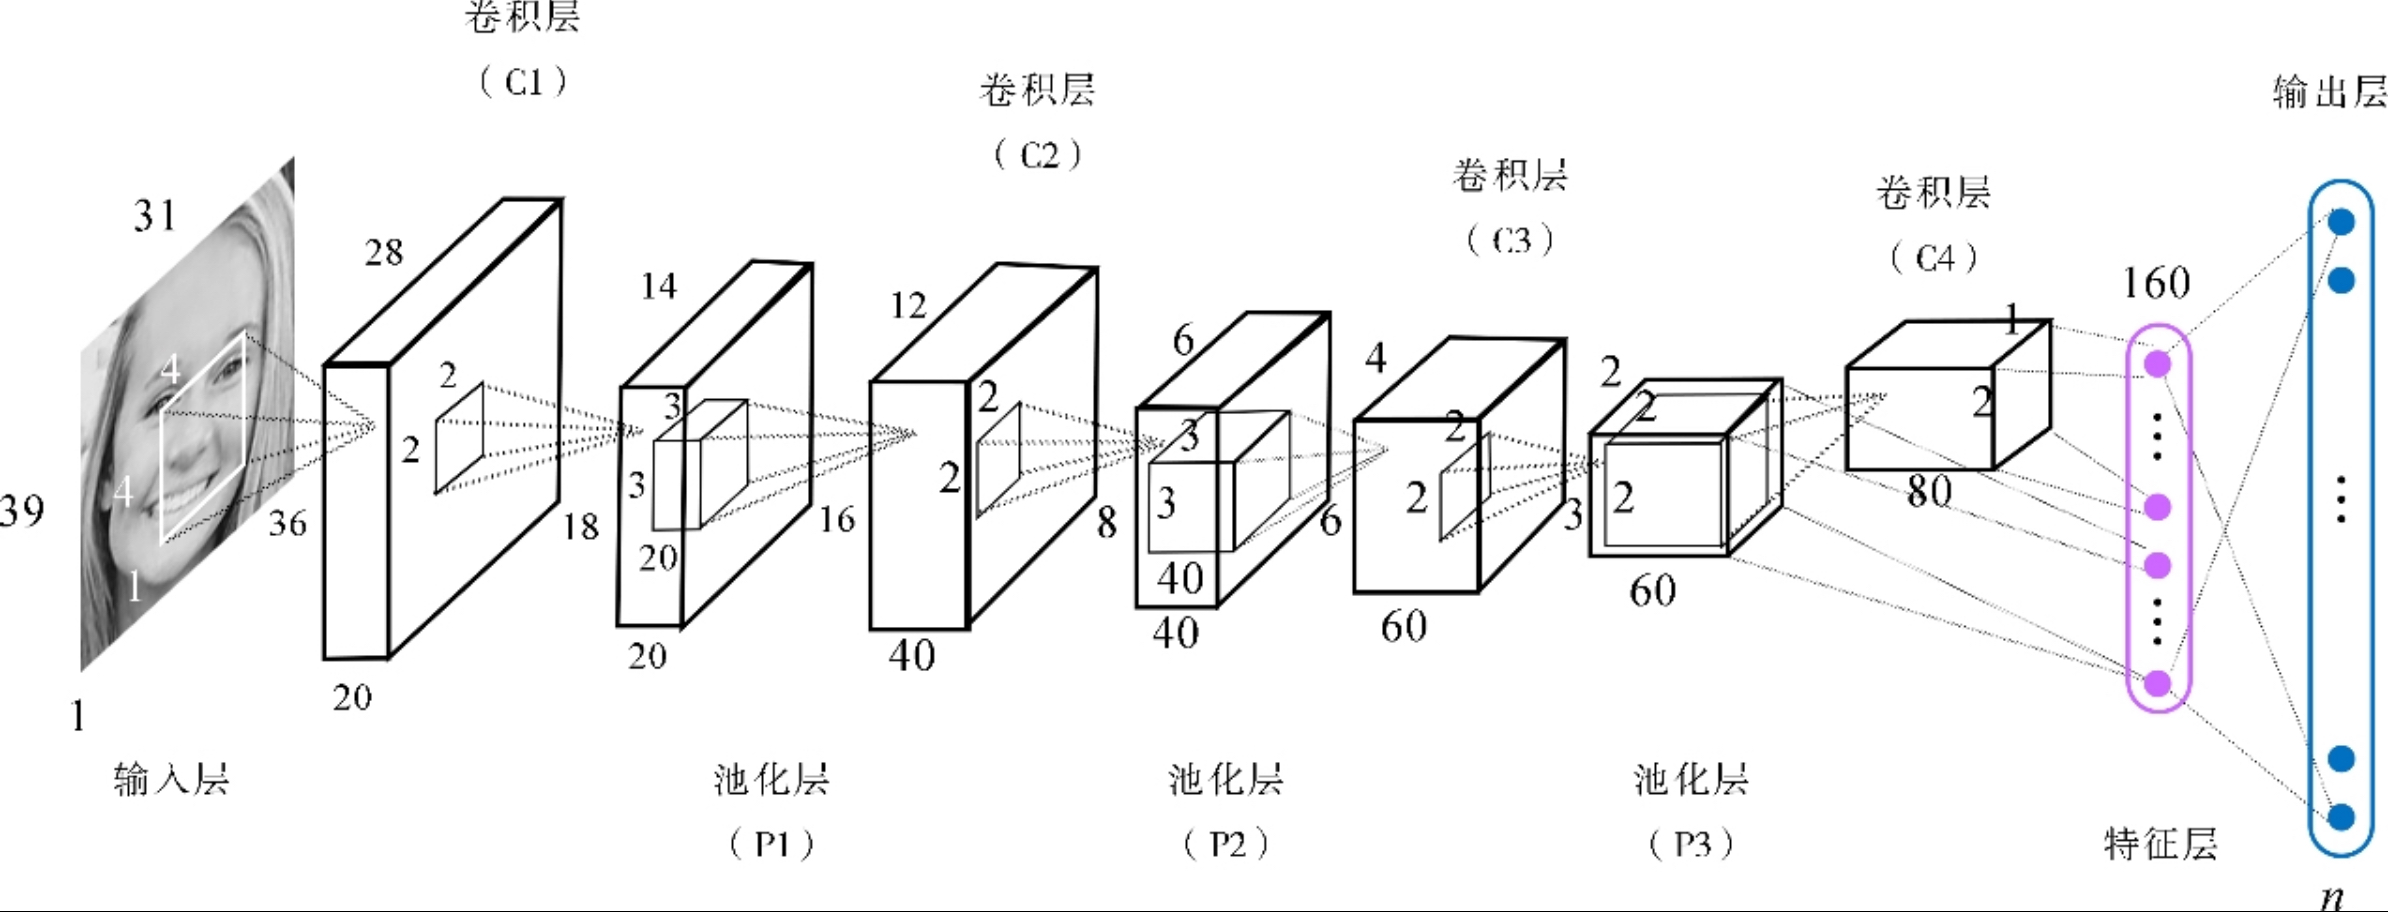

In [2]:
photo_paths = []
for i in range(1, 100):
    photo_paths.append("/content/drive/MyDrive/Colab Notebooks/convolutional neural network/{}.jpg".format(i))

from IPython.display import Image
Image(filename=photo_paths[0])

可以看到，卷积神经网络由若干个方块盒子构成，盒子从左到右仿佛越来越小，但越来越厚；最左边是一张图像，最右边则变成了两排圆圈。其实每一个方块都是由大量神经元构成的，只不过它们排成了立方体的形状。

**左边图象上的每个元素相当于一个神经元，构成了这个卷积神经网络的输入单元。**最右侧的圆圈也是神经元，它们排列成了两条直线，构成了该网络的输出。

卷积神经网络其实也是一种前馈神经网络，承载了深层的信息处理过程。信息从左侧输入，经过层层加工处理，最后从右侧输出。**对于图像分类任务而言，输入的是一张图像，历经一系列卷积层、池化层和完全连接层的运算，最终输出一组分类的概率，要分成多少类别，就有多少个输出神经元。**

相邻两层的神经元连接用上图中的小立体锥近似表示，实际上这种锥形遍布更高一层（右侧）立方体中的所有神经元。

**低层（左侧）到高层（右侧）的运算主要分为两大类：卷积和池化。一层卷积，一层池化，这两种运算交替进行，直到最后一层，我们又把立方体中的神经元拉平成了线性排列的神经元，与最后的输出层进行全连接。**

### **1.1手写数字识别任务的卷积神经网络及运算过程**

以手写数字识别任务为例来进一步认识卷积神经网络，该任务的输入是一张28X28的灰度图像，如下图所示。图中包含一个手写的数字，输出就是卷积神经网络识别出来的数字。

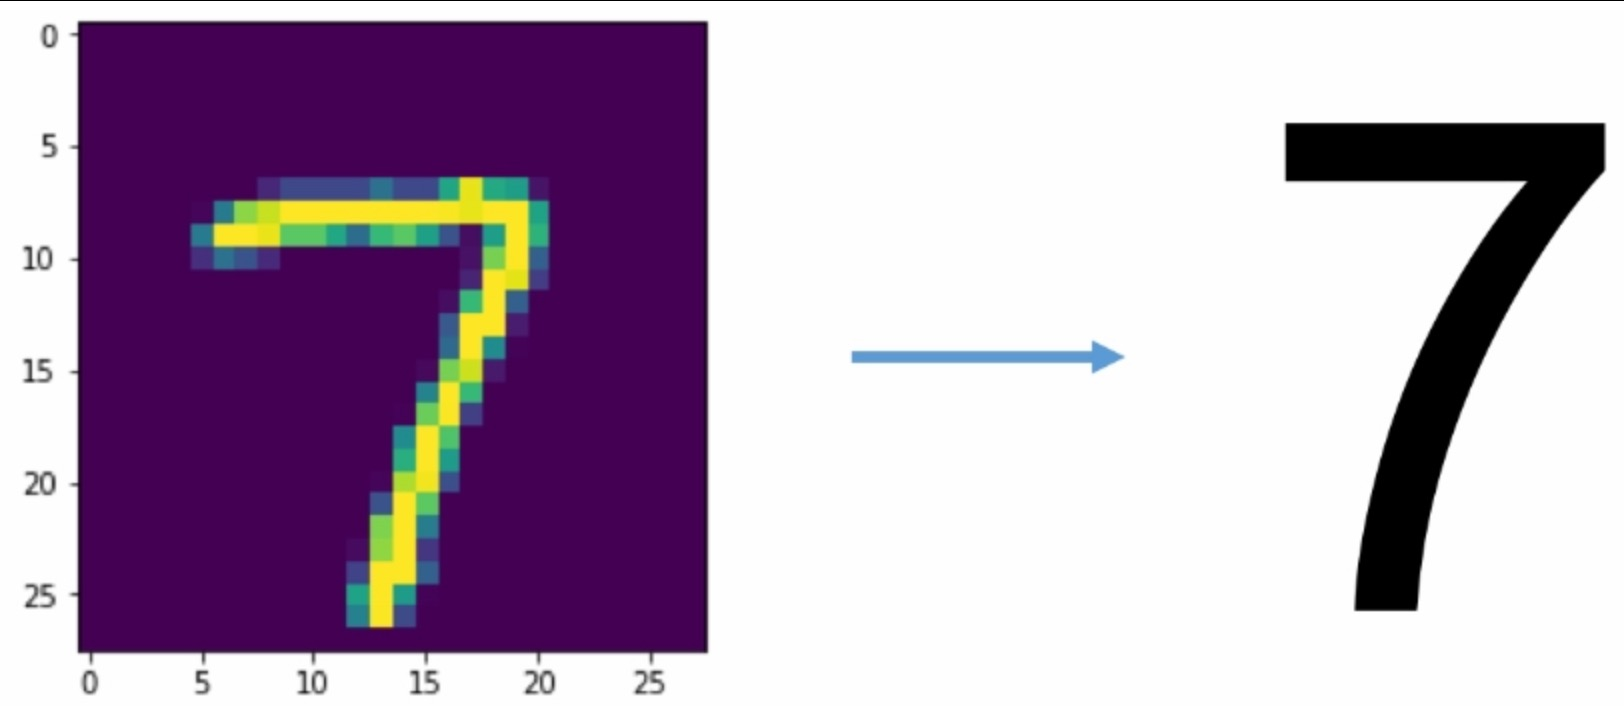

In [3]:
Image(filename=photo_paths[1],width=1100,height=500)

计算机中，输入的图像被表示成了一个尺寸为（28,28）的张量，其中张量的任意一个元素都是一个0-255的数字，表示该像素点的灰度值，越接近255，这个点就会白。这些输入像素点自然构成了卷积神经网络的输入神经元，因此，输入神经元排布成一个正方形。

为完成这个手写数字识别任务，设计了如下图所示架构的卷积神经网络**（在具体的设计网络架构时，网络的层数，每一层的神经元，都可以作为超参数重新选择）**

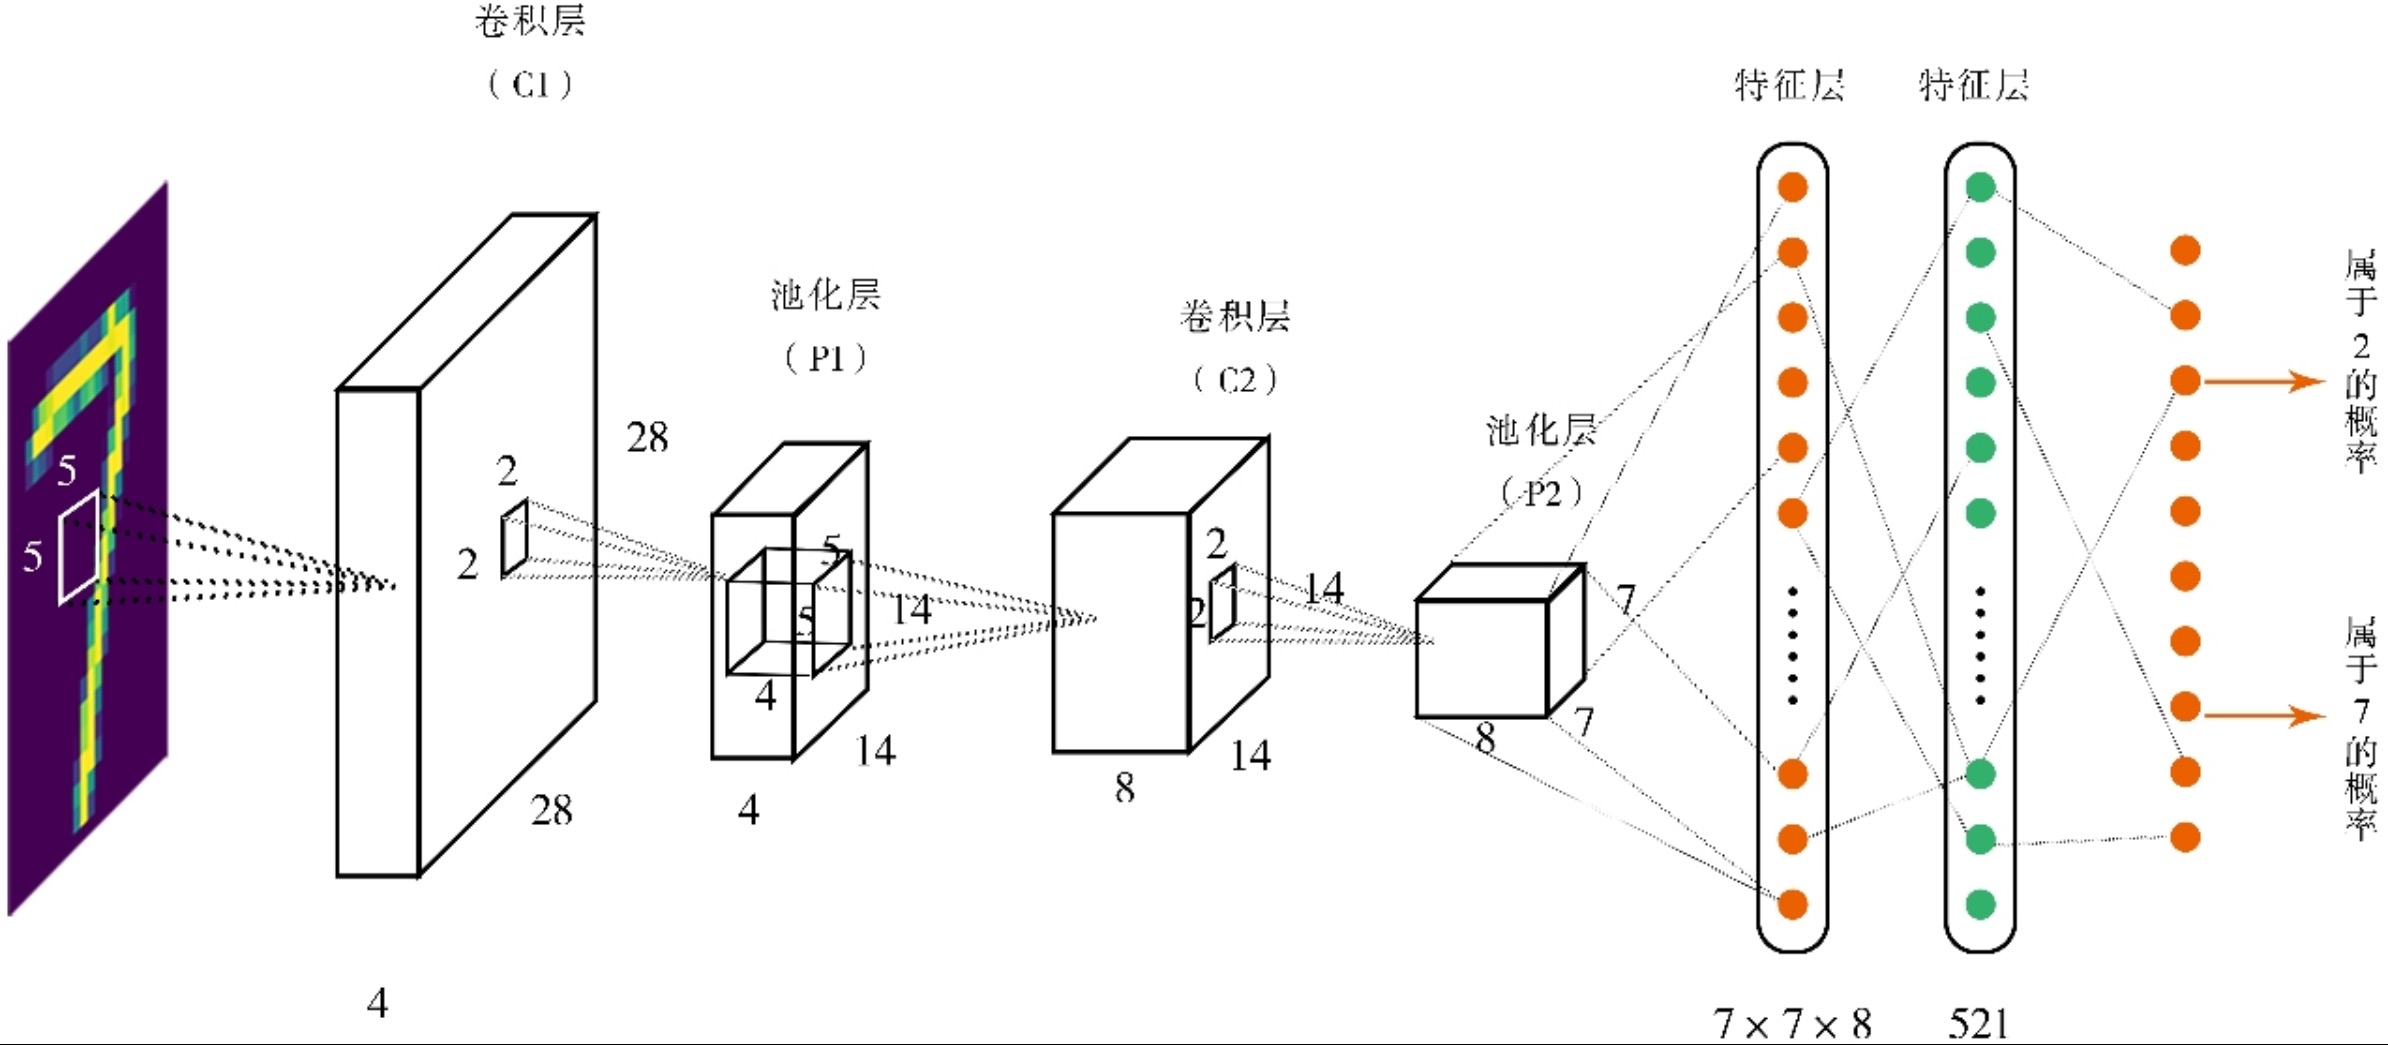

In [4]:
Image(filename=photo_paths[2],width=1000,height=500)

整个架构可以分为两大部分，第一部分是由输入图像和4个立方体构成的图像处理部分，其中图像被不断加工成尺寸更小，数量更多的图像；第二部分是由一系列线性排布的神经元构成的普通前馈多层神经网络。

深入看这个卷积神经网络的信息处理过程。首先，输入图像经过一层卷积元素，变成了图中第一个立方体，尺寸为（28,28,4）。实际上，这是4张28X28的图像。之后，这些图像经过池化运算，尺寸缩小了一半，变成了4张14X14的小图，排布成了厚度为4、长宽为14的立方体；之后，这些图形又经历了一次卷积运算，变成了8张图像，尺寸仍然为14X14；最后，这8张图像又经历了一次池化运算，尺寸又变小一半，成为8张7X7的小图片。


**（池化层数据变少，卷积层数据变厚，卷积层变厚的厚度就是卷积核的数量）**

 至此，第一部分的图像运算完成，下面进入第二部分。第二部分的结构和运算过程与基础的分类神经网络没有本质区别。首先，我们**将392(8×7×7)像素的神经元拉伸为一个长度为392的向量**，这些神经元构成了前馈神经网络部分的输入单元，之后经过一层隐含层，再映射到输出单元，**输出10个(0, 1)区间中的小数，表示隶属于0~9这10个数字的概率，且这些数字加起来等于1。**最后，我们再选取最大的数值所对应的数字，作为最后的分类输出。


**所有的卷积、池化运算都是依靠两层之间的神经元连接完成的**，这些连接与普通的前馈神经网络的连接并无本质区别，也对应了一组权重值。我们用这组权重值乘以相应的输入神经元就得到了计算结果。同理，第二部分网络的一层层运算也是由层与层之间的神经元连接完成的，它们也有相应的权重值。

整个卷积神经网络的运作与前两章介绍的神经网络一样，也分成了两个阶段：**前馈运算阶段和反馈学习阶段。**在网络的前馈阶段（从输入图像到输出数字），所有连接的权重值都不改变，系统会根据输入图像计算输出分类，并根据网络的分类与数据中的标签（标准答案）进行比较，**计算出交叉熵作为损失函数**。接下来，在反馈阶段，根据前馈阶段的损失函数调整所有连接上的权重值，从而完成神经网络的学习过程。整个过程与前一章介绍的前馈神经网络类似。



### **1.2 卷积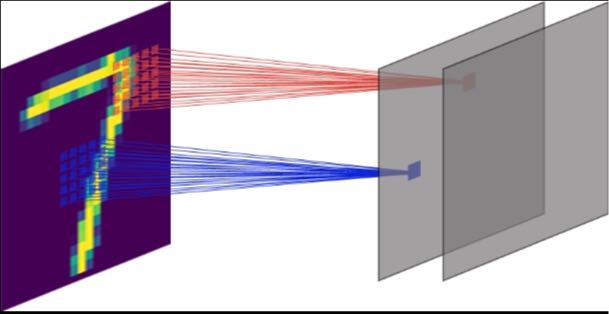的概念**

举个例子，假设卷积神经网络接收的原始输入图片是下面的左图，它由一系列包含灰度信息的像素构成。与此同时，卷积神经网络的一次卷积运算需要相应的卷积核。卷积运算就是在原始图像中搜索与卷积核相似的区域，即用卷积核从左到右、从上到下地进行逐个像素的扫描和匹配，并最终将匹配结果表示成一个新的图像，即特征图。

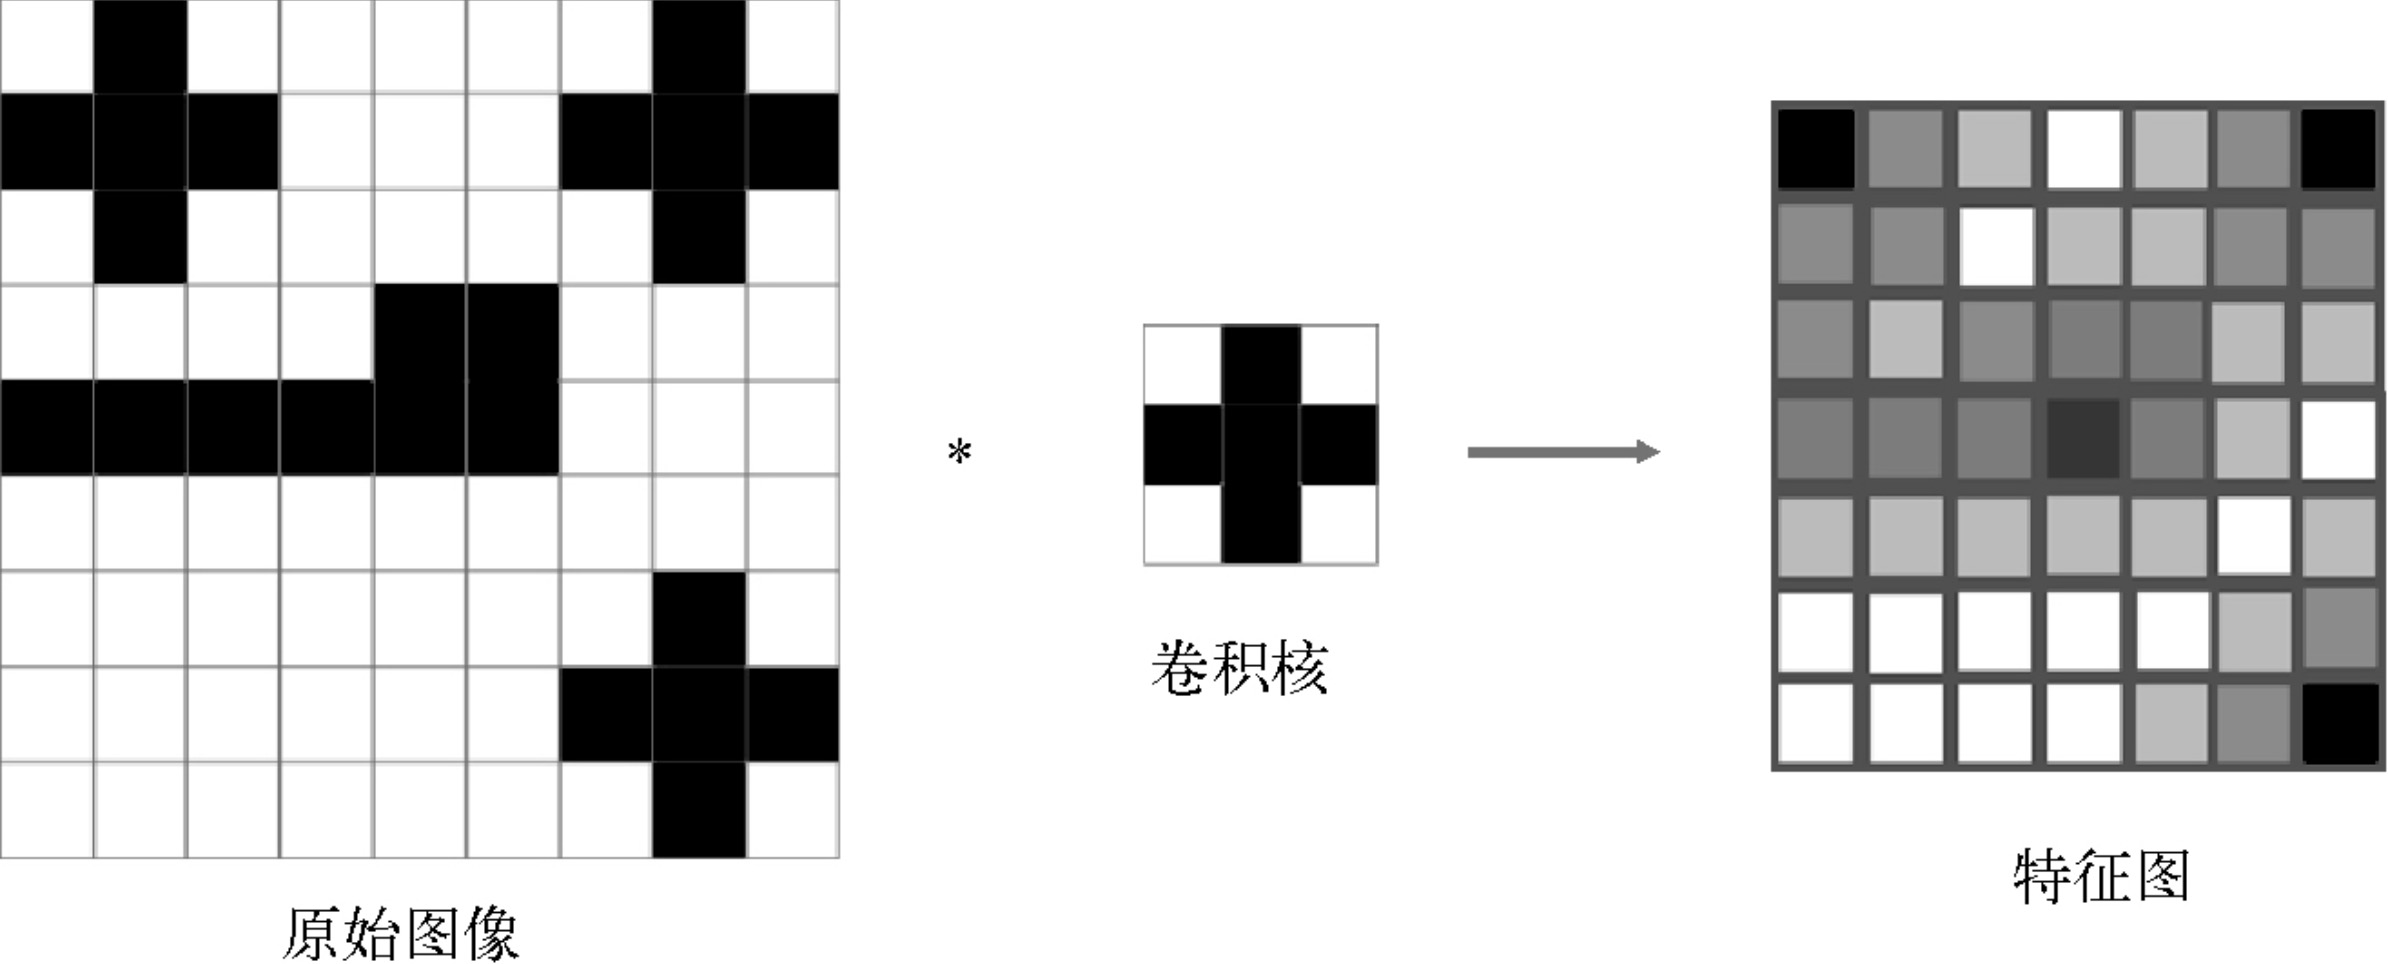

In [5]:
Image(filename=photo_paths[3],width=900,height=350)

特征图上有灰有白，每个像素灰度的高低代表了模板与原始图像相应位置的匹配程度，相似程度越高，就越白。


在数学，图像要先数值化，变成矩阵，其中数值是0-255的整数；其次，将卷积核数值化看成是一张3X3的小图，每个像素都是一个实数值对应卷积神经网络的权重。

卷积运算是一个多步的过程。第一步，卷积核与原始图像左上角第一片3X3的区域做内积，将对应位置相乘数字相加，结果就会输出为特征图左上角第一个像素。

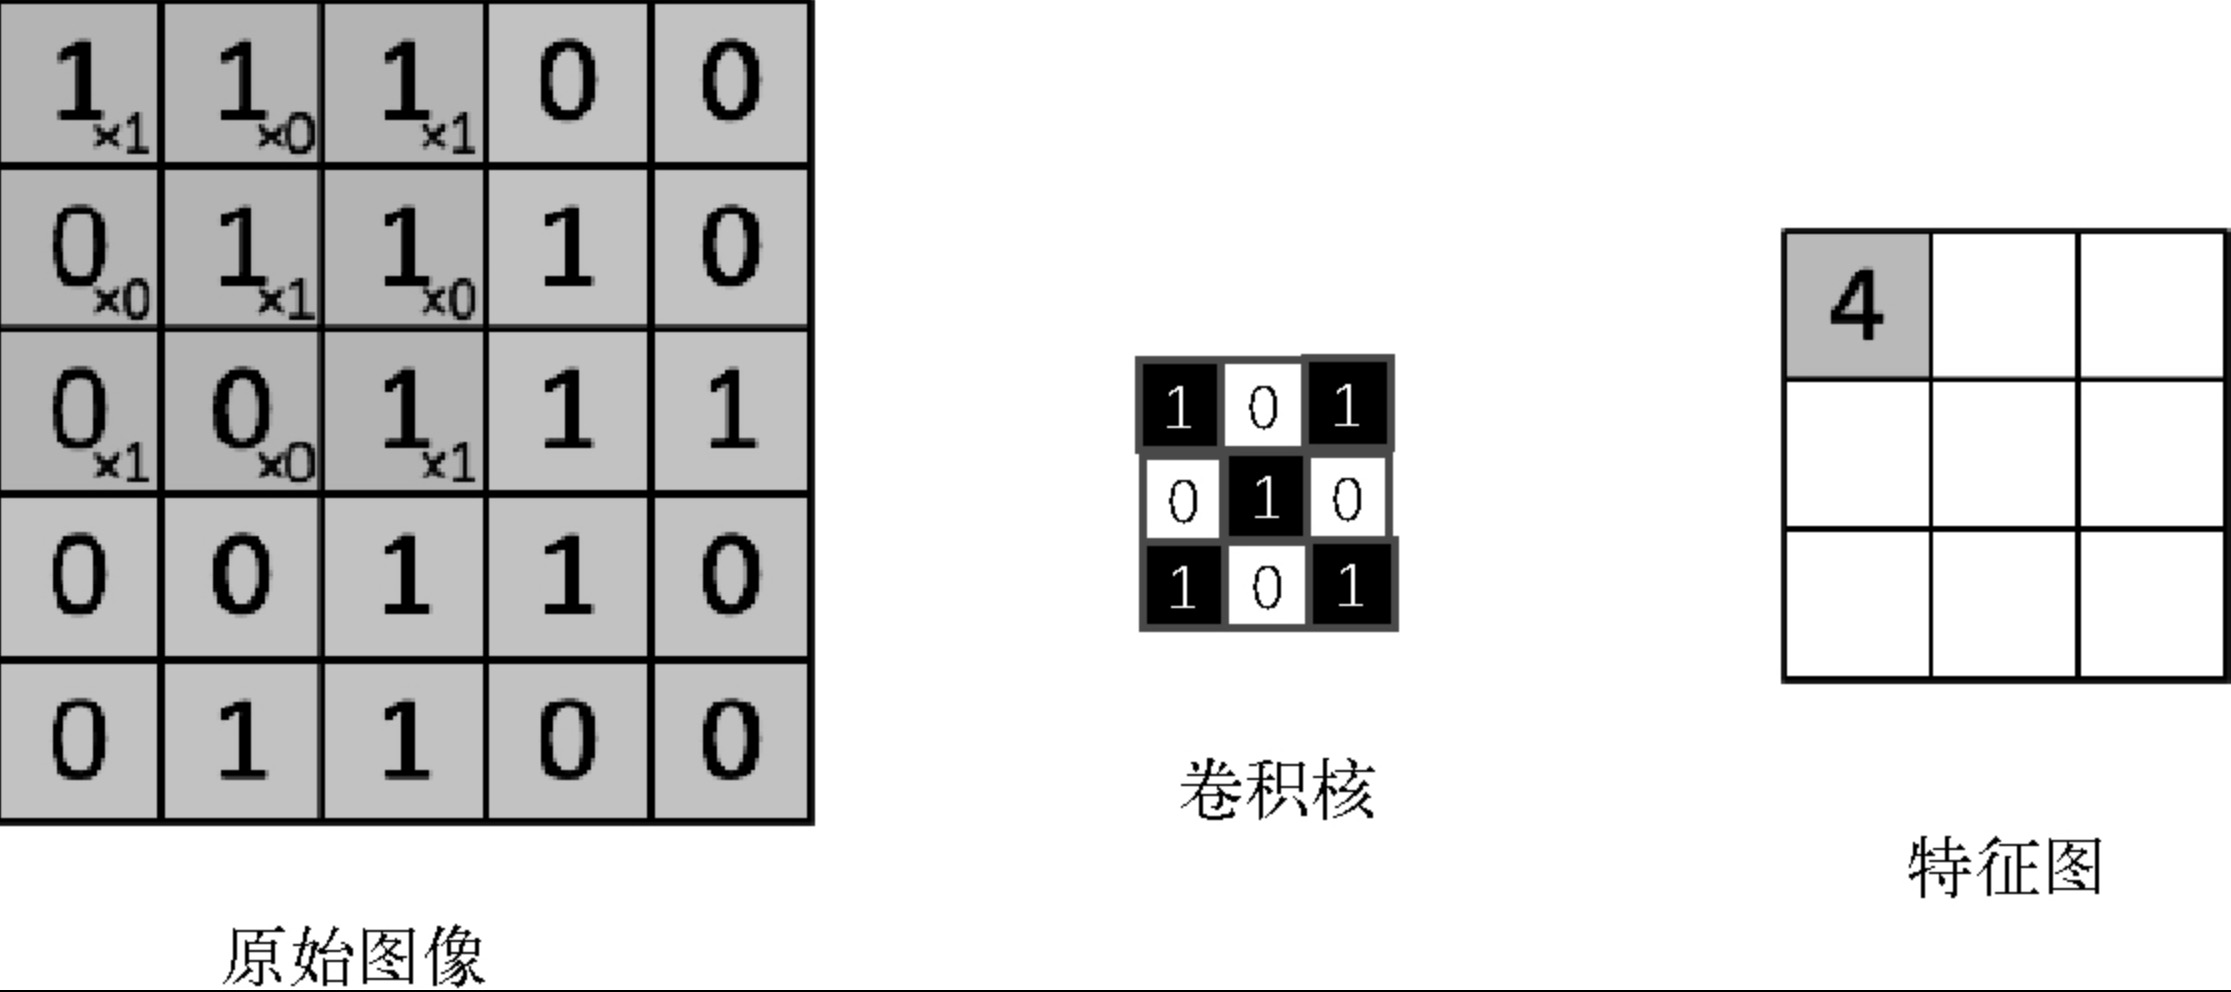

In [6]:
Image(filename=photo_paths[4],width=900,height=350)

接着就是左上角第二片的区域做内积，依次类推，最终得到所有特征图的像素，覆盖了原始图像，那么这过程计算就完成了。

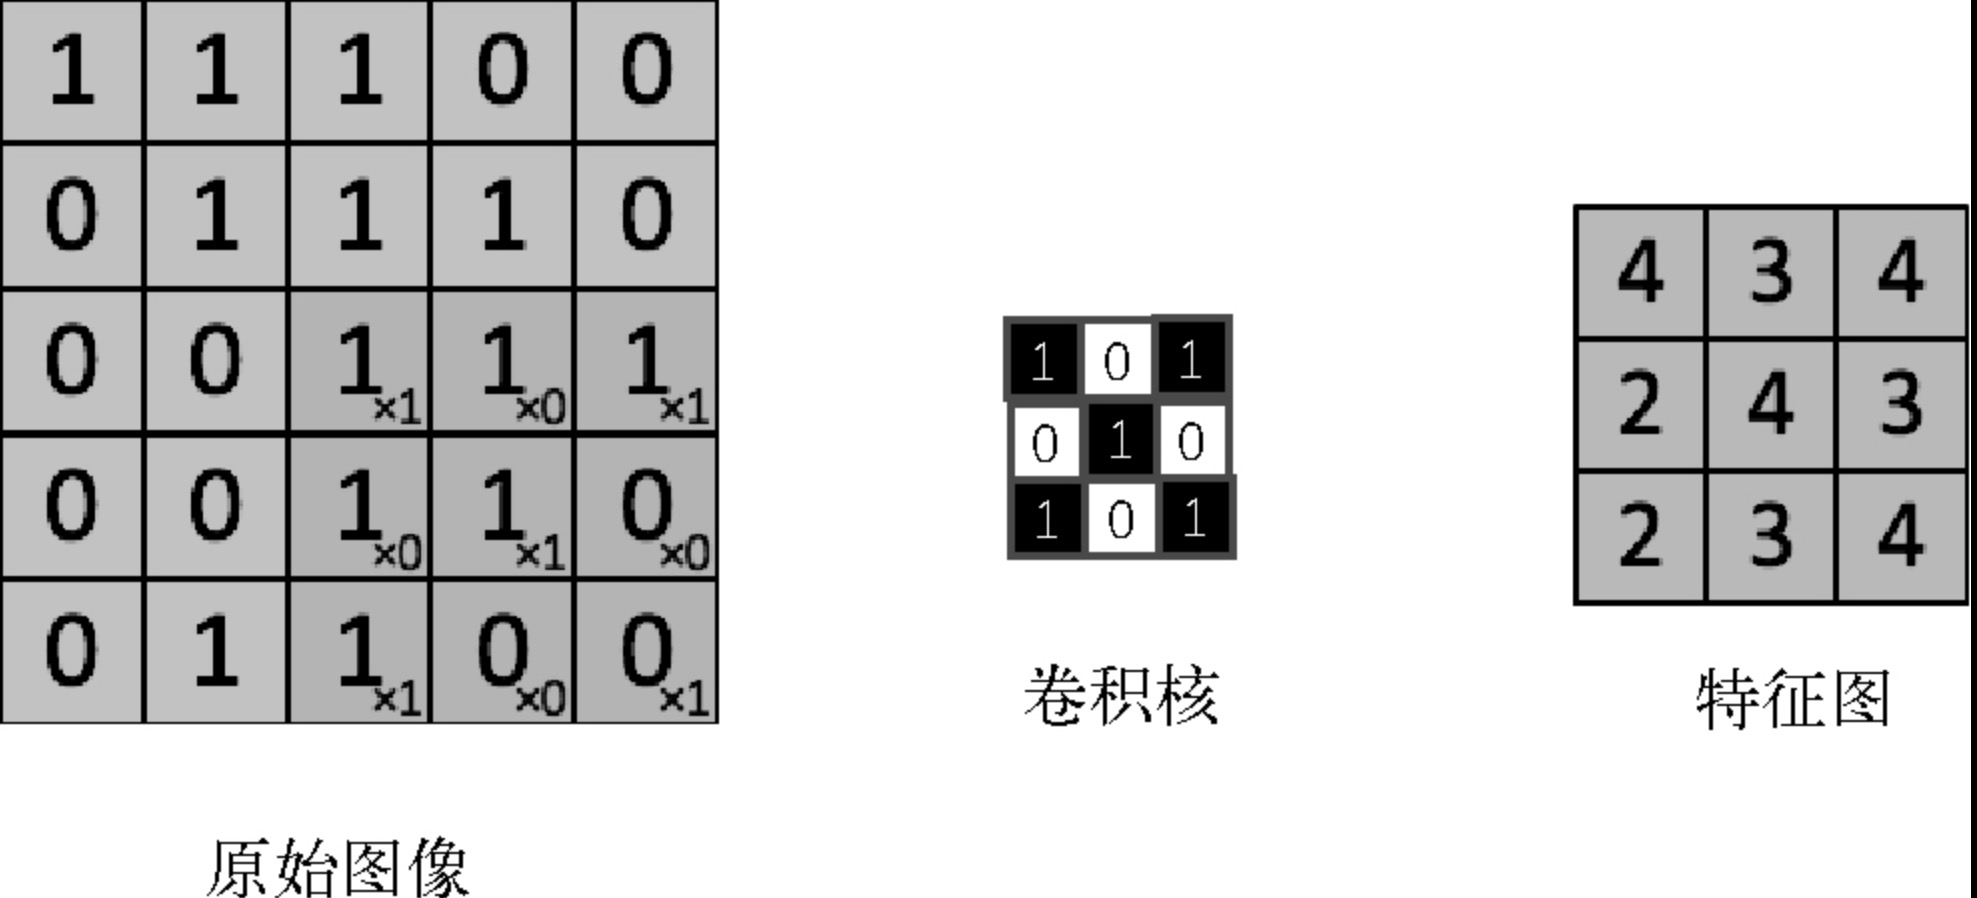

In [7]:
Image(filename=photo_paths[5],width=900,height=350)

假设原始图的尺寸是 $n$ ，卷积核的宽度是 $w$ ，特征图的大小一般是 $(n-w+1)(n-w+1)$ ,所以特征图会比原始图像小一点。 **如果不想让特征图变小，那么就需要采用补齐（padding）技术将原始图扩大，并用0来填充补充的区域。**

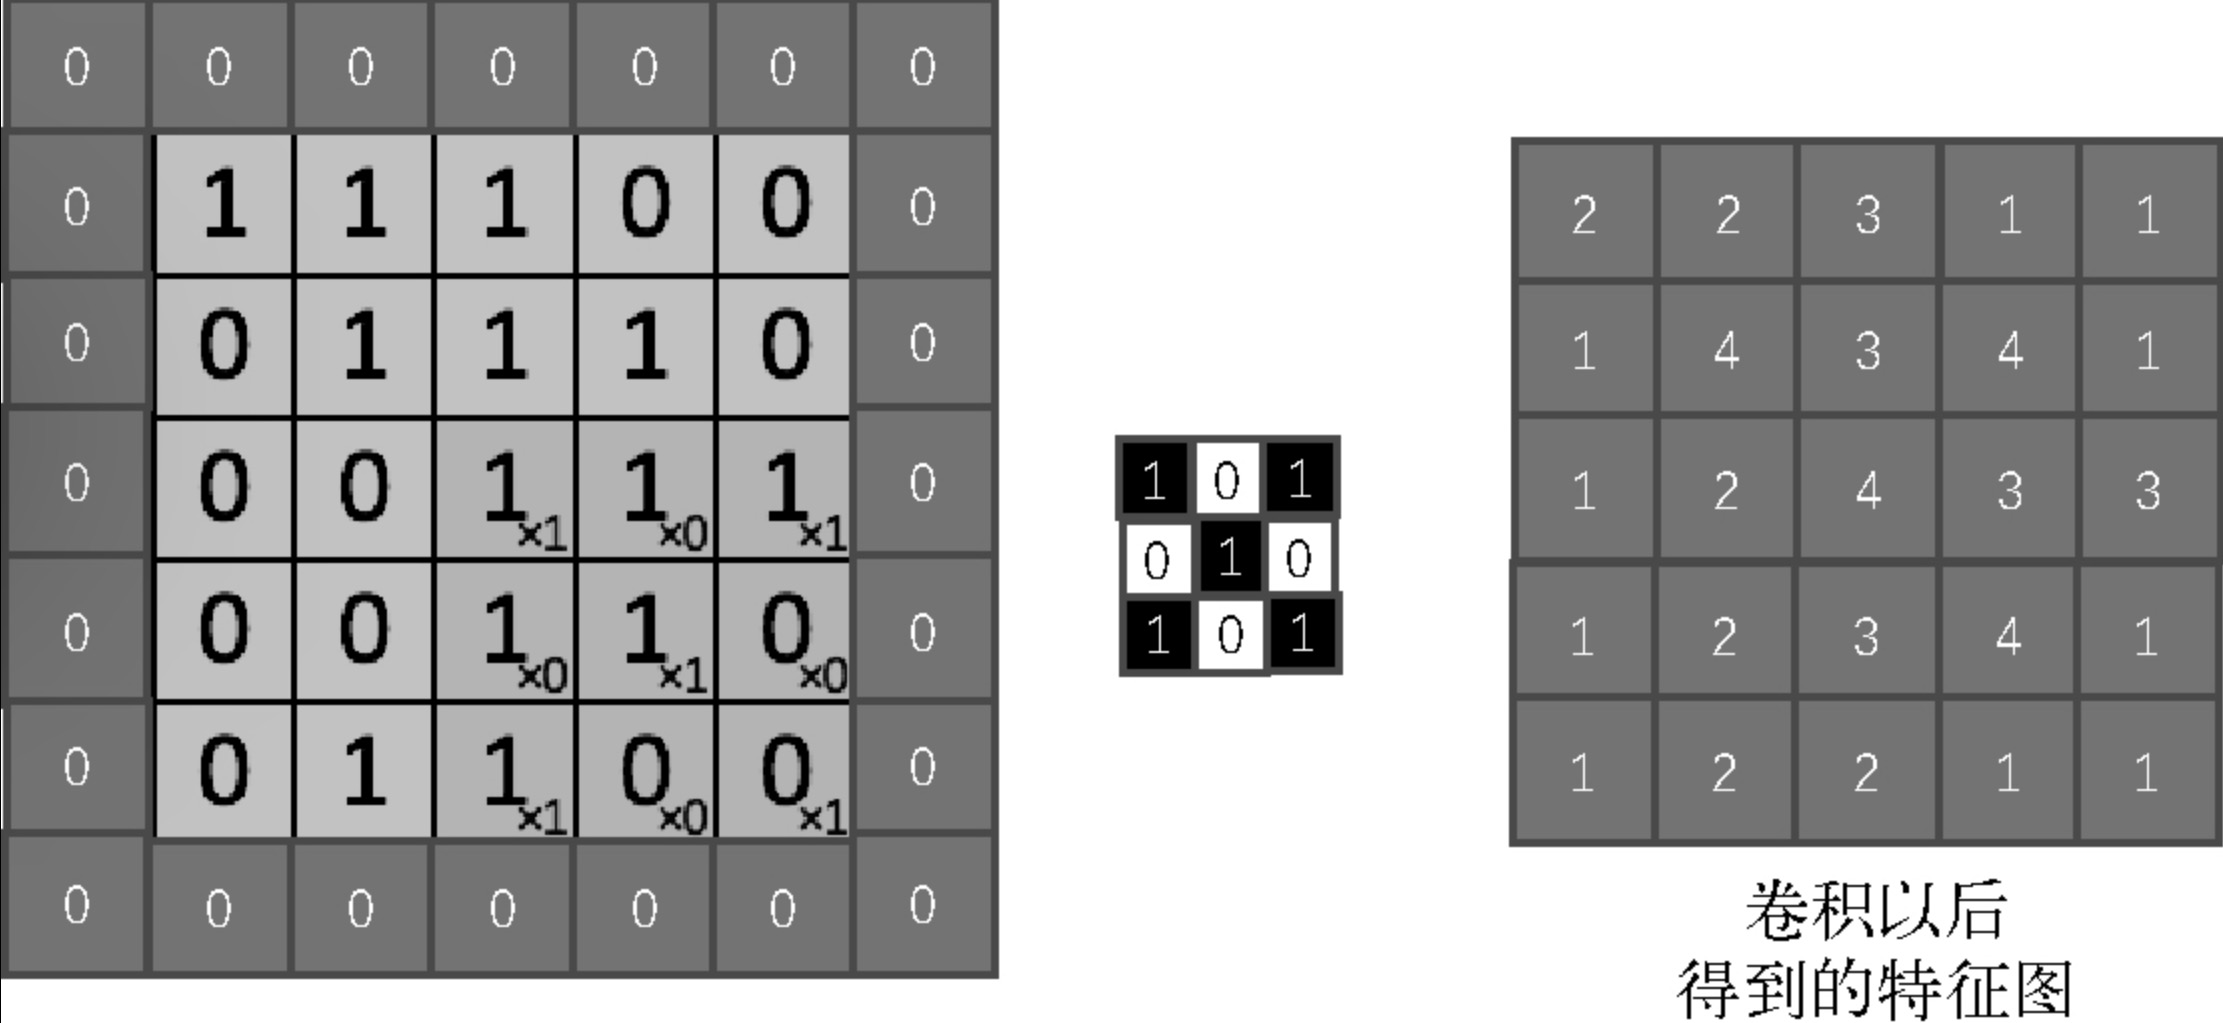

In [8]:
Image(filename=photo_paths[6],width=900,height=350)

对于同一张原始输入图像，可以用不同的卷积核与其相作用，每个卷积核相当于不同的模板，每一个卷积核在原始图像的运算结果都能得到不同的特征图。

从神经网络的角度看，特征图上每一个像素（神经元）都和原图上3X3大小的一个方形区域的像素相连（即9个连接），每条连边对应卷积核小矩阵的一个单元，数的大小对应连边上的数字，称为权重值。该权重值可以学习和调节。

一层卷积可能有多个卷积核，用不同颜色表示。

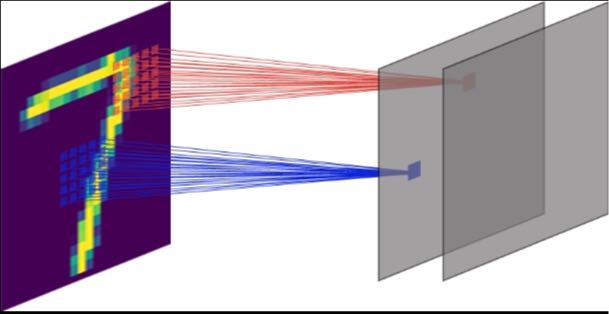

In [9]:
Image(filename=photo_paths[7],width=900,height=400)

我们可以将多个特征图拼在一起组成立方体，从而表示多个特征图。 **因此，立方体的厚度是多少，就有多少特征图，也就有多少个卷积核。** 下图是一个厚度为100的特征图，即100个125X125的特征图，有100个卷积核。

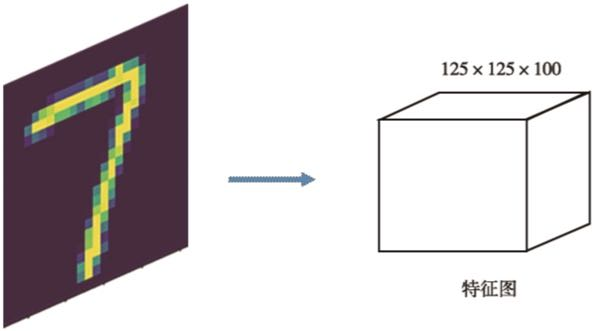

In [10]:
Image(filename=photo_paths[8],width=900,height=500)

### **1.3池化运算**

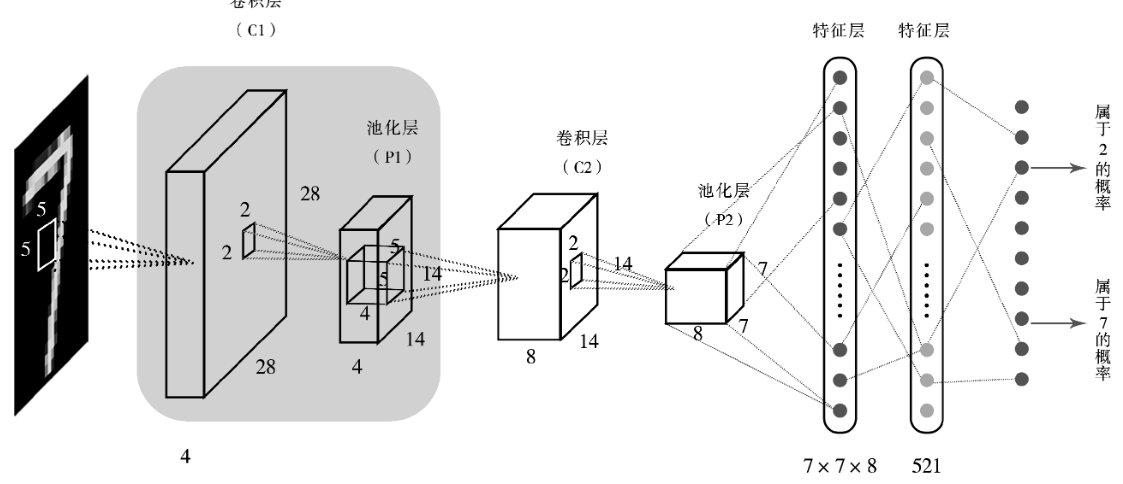

In [11]:
Image(filename=photo_paths[9],width=1100,height=500)

上图中左边的阴影区域就是池化运算部分，下图是经过3步池化运算的结果。

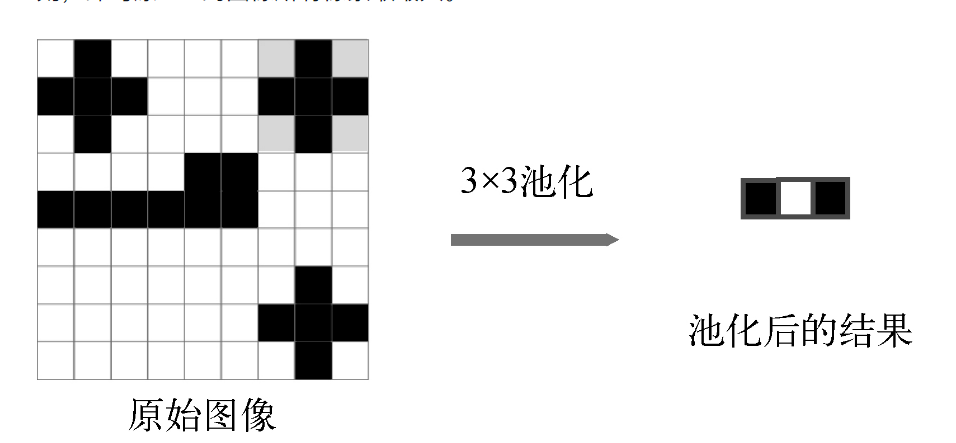

In [12]:
Image(filename=photo_paths[10],width=1100,height=500)

每一步池化都是将图像中的一片3X3区域变成一个像素点，新像素的取值按照最大原则，即对原3X3的图像所有像素取最大。**（这个图片不太对按理来说 （9X9的图片这样池化应该变成3X3的图片）**

一张9×9的原始图像做3×3的池化运算，就是对每一个3×3的小块压缩信息，即取所有3×3中的最大值，从而作为一格像素点输出。我们可以想象一个3×3的小窗口在原图上从左到右、从上到下地间隔3个格跳动**（无重叠地移动，这一点与卷积不同）**，从而每一步形成一个局部3×3小块的信息汇总，输出到右侧的池化结果图中。最终扫描完整张图像，就会得到一张池化结果的小图，**这张图是对原始图像的缩略与抽象。**这个过程相当于我们只能知道3×3的小块里有个东西，无法看清其中的细节。然后，我们对所有不重叠的3×3区域都做这个运算，就会得到一张3×3的输出图像，它的大小是原始图像的1/9。

**池化时，我们不仅可以求窗口像素的最大值，而且可以求平均值，这只是不同的池化方法。**当输入多张图像时，只要对每一张图像都做相同的池化运算就行。

### **1.4立体卷积核**

接下来是第二个卷积核的运算，与第一个卷积运算最大的不同就在于卷积的输入不再是二维的图像，而是三维的立方体，也就是一组二维的图像。这种的情况下，卷积的方式也会跟着改变。

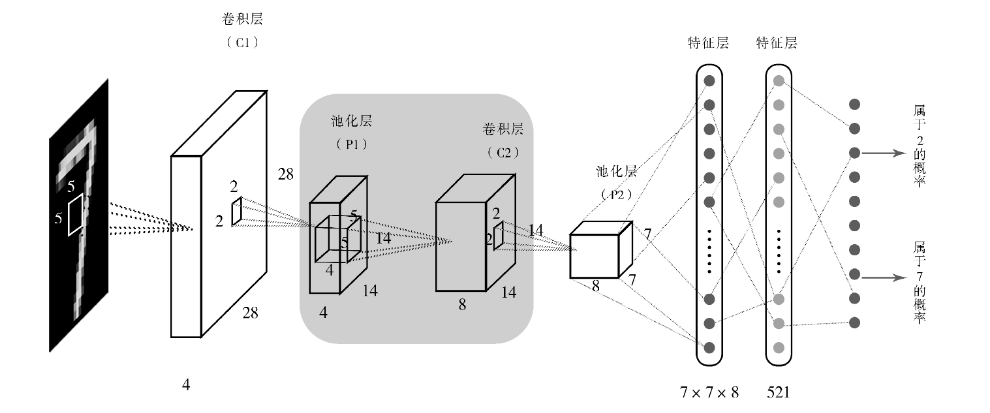

In [13]:
Image(filename=photo_paths[11],width=1100,height=500)

假设卷积核的窗口大小仍然是5×5，输入的特征图厚度是4，那么一个卷积核就是一个尺寸为(4, 5, 5)的三维张量，即一个长方体。

与第一层卷积类似，这里的一个卷积核就体现为从左侧输入特征图到右侧输出特征图之间的连接，只不过，右侧的一个像素点要连接左侧的一个4×5×5的小长方体中的所有像素点。


在做卷积运算的时候，我们**同样是将每一个长方体中的像素与相应的连接权重相乘，然后再把所有的乘积相加，得到输出特征图上一点的像素值**。

需要注意的是，**输出特征图有多少层，这一层卷积就有多少个卷积核，每一个卷积核会完全独立地进行运算。**另外，对于原始输入图像有多个通道的情况（例如，一般的彩色图像就有RGB这3个通道），我们将其等同于输入为长方体的情况。之后，卷积神经网络会再做一次窗口为2×2的池化运算，过程与上一节介绍的类似，在此不再赘述。

### **1.5 超参数与参数**

基本介绍了基础运算，卷积和池化。接下来，综合来计算一下整个网络中有多少超参数和参数。

**超参数，即人为设定的参数值，往往决定了整个网络的架构。**在卷积神经网络中，**网络参数、每层神经元数量、卷积核窗口大小（在图片滑动的大小）、每一个卷积层卷积核的数量、填充格点的大小以及池化运算中池化窗口大小**都是超参数。除此之外，全连接层也有相应的层数和神经元数量作为超参数。

参数，是那些不需要人为设定、在网络的训练过程中网络自动学到的数值。首先，来看一下每一层卷积运算有多少个参数。一层卷积运算就是将原始图像与卷积核做内积，然后平移所有的像素点。**因此，参数的数量其实就是卷积核的尺寸（滑动后加权得到的），以及这一层有多少个卷积核。**

假设输入的特征图的尺寸为$(c,w,h)$， 即厚度$c$、长$w$、宽$h$；输出特征图尺寸为$(b,u,v)$,卷积的窗口大小都为$s$,那么这一层的参数数量就是$b*c*s^2$,跟输入输出图像的长宽没有关系。

其次，针对池化层，由于所有的运算都是固定的，即求最大像素值或者求窗口内的像素平均值，**这一运算过程不需要设定任何参数，因此池化层是没有参数的。**

由此可见，尽管卷积神经网络看起来比普通神经网络具有更复杂的架构和神经元连接，但是它的参数很少，因此学习会更加高效，可以很轻易地叠加组成更深的网络，完成艰巨的任务。

#### **1.5.1 卷积神经网络的反向传播算法**

























































前面讲述了卷积神经网络的前馈运算过程，在网络的训练过程中，还需要计算反向传播的误差。

卷积运算虽然与普通的神经网络运算非常相似，但卷积核会沿着输入图像平移；池化运算则会将图像压缩。**因此，看起来普通神经网络的反向传播(BP)算法并不能直接用在卷积和池化运算上，而需要使用适合它们的特殊BP算法。**

所幸，卷积与池化以及构建卷积神经网络过程中的所有计算都是可微分的，这样我们就可以利用PyTorch的动态计算图调用backward函数自动计算出每个参数的梯度，并最终完成BP算法。

#### **1.5.2 卷积神经网络为何能很好工作**

首先，卷积运算可以实现各种各样的图像运算。我们知道，绝大部分的图像处理运算，**诸如锐化图像（强调细节）、模糊图像（减少细节），可以看作特定权重的卷积核在原始图像上的卷积运算。**换句话说，这些运算都是可被卷积神经网络学习到的。于是，学好的卷积核就能对图像进行去噪、提炼等信息过滤和提取工作。

其次，卷积神经网络中的池化运算可以提取大尺度特征。池化运算就是忽略图像中的细节信息，从而提炼出图像中的大尺度信息。这些信息可以帮**助卷积神经网络从整体上把握图像的分类。**这样，当我们把多层的卷积和池化运算串联起来形成一个多层卷积神经网络的时候，它就可以逐个尺度地处理信息了，如下图所示

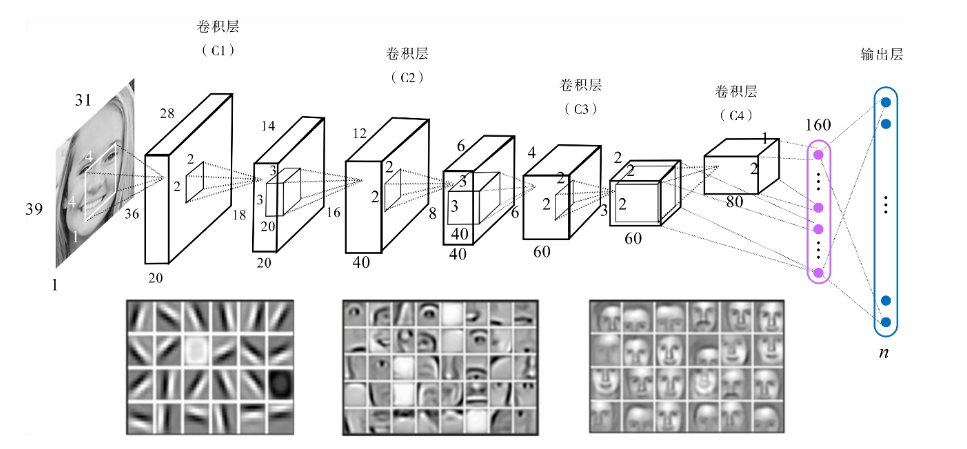

In [14]:
Image(filename=photo_paths[12],width=1100,height=500)

## **2. 手写数字识别器**

基本卷积神经网络的原理介绍完之后，尝试用PyTorch搭建一个卷积神经网络，并用它来解决手写数字识别的问题。

### **2.1 数据准备**

首先导入所有需要的库

In [15]:
# 导入所需要的包，请保证torchvision已经在环境中安装好
# 在Windows中，需要单独安装torchvision包，在命令行运行pip install torchvision即可
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

# 以下语句可以让Jupyter Notebook直接输出图像
%matplotlib inline

接着定义一些训练用的超参数

In [16]:
image_size = 28  # 图像的总尺寸为28×28
num_classes = 10  # 标签的种类数
num_epochs = 20  # 训练的总循环周期
batch_size = 64  # 一个批次的大小，64张图片

PyTorch自带了一系列数据集，其中就包括我们将使用的手写数字数据集MNIST（这是一组手写数字的图像），还开发了数据处理的包，封装了处理数据集的常用功能，可以将各种数据类型转换成张量，方便以后的批训练。下面我们将学习PyTorch自带的数据加载功能，包括dataset、sampler和data loader这3个对象组成的套件，它们定义在了torch.util.data数据集对象里。

由于神经网络的训练需要对数据进行分批前馈传递和反向传播，所以需要将原始数据处理成批的形式，而接下来的数据加载器可以很好地解决这个问题：

In [17]:
# 加载MNIST数据，如果没有下载过，系统就会在当前路径下新建/data子目录，
# 并把文件存放其中（压缩的格式）
# MNIST数据是torchvision包自带的，可以直接调用
# 当用户想调用自己的图像数据时，可以用torchvision.datasets.ImageFolder
# 或torch.utils.data.TensorDataset来加载
train_dataset = dsets.MNIST(root='./data',  # 文件存放路径
        train=True,   # 提取训练集
        # 将图像转化为张量，在加载数据时，就可以对图像做预处理
        transform=transforms.ToTensor(),download=True) # 当找不到文件的时候，自动下载

# 加载测试集
test_dataset = dsets.MNIST(root='./data',train=False,transform=transforms.ToTensor())

# 训练集的加载器，自动将数据切分成批，顺序随机打乱
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)

'''我们希望将测试数据分成两部分，一部分作为校验数据，另一部分作为测试数据。
校验数据用于检测模型是否过拟合并调整参数，测试数据用于检验整个模型的工作'''


# 首先，定义下标数组indices，它相当于对所有test_dataset中数据的编码
# 然后，定义下标indices_val表示校验集数据的下标，indices_test表示测试集的下标
indices = range(len(test_dataset))
indices_val = indices[:5000]
indices_test = indices[5000:]

# 根据下标构造两个数据集的SubsetRandomSampler采样器，它会对下标进行采样
sampler_val = torch.utils.data.sampler.SubsetRandomSampler(indices_val)
sampler_test = torch.utils.data.sampler.SubsetRandomSampler(indices_test)

# 根据两个采样器定义加载器
# 注意将sampler_val和sampler_test分别赋值给了validation_loader和test_loader
validation_loader = torch.utils.data.DataLoader(dataset =test_dataset,batch_size = batch_size,shuffle = False,sampler = sampler_val)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle= False,sampler = sampler_test)

100%|██████████| 9912422/9912422 [00:00<00:00, 106867995.53it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 26570672.04it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32166338.28it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19599309.43it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



PyTorch提供了管理数据集的工具包，方便我们对数据集进行切分、采样和统一管理。

·**数据集(dataset)是对整个数据的封装，无论原始数据是图像还是张量，数据集都将对其进行统一处理。**我们可以像访问数组的元素一样访问数据集中的元素。

·**加载器(dataloader)主要负责在程序中对数据集的使用。**例如，我们在训练神经网络的过程中需要逐批加载训练数据，加载器就会自动帮我们逐批输出数据。使用加载器比直接使用张量手动加载数据更好，因为当数据集超大的时候，我们无法将所有数据全部装载到内存中，必须从硬盘上加载数据，而加载器可以让这一过程自动化。

·**采样器(sampler)为加载器提供了一个每一批抽取数据集中样本的方法。**我们可以按照顺序将数据集中的数据逐个抽取到加载器中，也可以完全随机地抽取，甚至可以依某种概率分布抽取。总之，数据集、加载器和采样器可以让数据的处理过程更加便捷和标准。**对于已经处理好的数据，我们可以直接根据索引去提取，并通过Python的绘图处理包将手写数字显示出来：**

标签是： 2


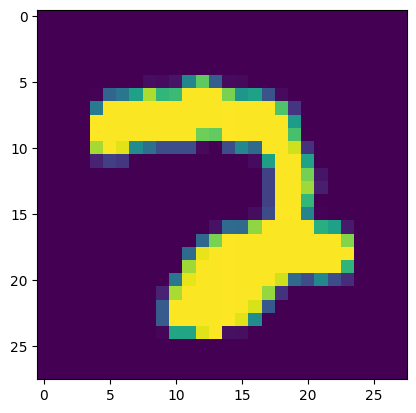

In [18]:
# 随便从数据集中读入一张图片，并绘制出来
idx = 120

# dataset支持下标索引，其中提取出来的元素为features、target格式，即属性和标签
# [0]表示索引features
muteimg = train_dataset[idx][0].numpy()
# 一般的图像包含RGB这3个通道，而MNIST数据集的图像都是灰度的，只有一个通道
# 因此，我们忽略通道，把图像看作一个灰度矩阵
# 用imshow画图，会将灰度矩阵自动展现为彩色，不同灰度对应不同的颜色：从黄到紫

plt.imshow(muteimg[0,...])
print('标签是：',train_dataset[idx][1])

### **2.2 构建网络**

处理完数据集之后，我们将构建一个经典的卷积神经网络来进行图片识别。这里将主要调用PyTorch强大的nn.Module类来构建卷积神经网络，步骤如下。

In [19]:
# 定义卷积神经网络：4和8为人为指定的两个卷积层的厚度（feature map的数量）
depth = [4, 8]

首先，构造ConvNet类，它是对nn.Module类的继承，即nn.Module是父类，ConvNet为子类。nn.Module中包含了绝大部分关于神经网络的通用计算，如初始化、前传等，用户可以重写nn.Module中的部分函数以实现定制化，如__init__()构造函数和forward()函数。

其次，复写__init__()和forward()这两个函数。__init__()为构造函数，每当类ConvNet被具体化一个实例的时候就会被调用。forward()函数则是在正向运行神经网络时被自动调用，它负责数据的向前传递过程，同时构造计算图。

再次，定义一个retrieve_features()函数，它可以提取网络中各个卷积层的权重。在后面对训练好的神经网络进行剖析的时候，我们会用到这个函数。最后，我们自定义一些方法，方便训练模型和衡量其性能。

In [20]:
class ConvNet(nn.Module):
    def __init__(self):
        # 该函数在创建一个ConvNet对象即调用语句net=ConvNet()时会被调用
        # 首先调用父类相应的构造函数
        super(ConvNet, self).__init__()

        # 其次构造ConvNet需要用到的各个神经模块
        # 注意，定义组件并不是真正搭建组件，只是把基本建筑砖块先找好
        # 定义一个卷积层，输入通道为1，输出通道为4，窗口大小为5，padding为2
        self.conv1 = nn.Conv2d(1, 4, 5, padding = 2)
        self.pool = nn.MaxPool2d(2, 2) # 定义一个池化层，一个窗口为2×2的池化运算
        # 第二层卷积，输入通道为depth[0]，输出通道为depth[1]，窗口为5，padding为2
        self.conv2 = nn.Conv2d(depth[0], depth[1], 5, padding = 2)
        # 一个线性连接层，输入尺寸为最后一层立方体的线性平铺，输出层512个节点
        self.fc1 = nn.Linear(image_size // 4 * image_size // 4 * depth[1] , 512)

        self.fc2 = nn.Linear(512, num_classes) # 最后一层线性分类单元，输入为512，输出为要分类的类别数

    def forward(self, x): # 该函数完成神经网络真正的前向运算，在这里把各个组件进行实际的拼装
        # x的尺寸：(batch_size, image_channels, image_width, image_height)
        x = self.conv1(x)  # 第一层卷积
        x = F.relu(x) # 激活函数用ReLU，防止过拟合
        # x的尺寸：(batch_size, num_filters, image_width, image_height)

        x = self.pool(x) # 第二层池化，将图片缩小
        # x的尺寸：(batch_size, depth[0], image_width/2, image_height/2)

        x = self.conv2(x) # 第三层卷积，窗口为5，输入输出通道分别为depth[0]=4, depth[1]=8
        x = F.relu(x) # 非线性函数
        # x的尺寸：(batch_size, depth[1], image_width/2, image_height/2)

        x = self.pool(x) # 第四层池化，将图片缩小到原来的1/4
        # x的尺寸：(batch_size, depth[1], image_width/4, image_height/4)

        # 将立体的特征图tensor压成一个一维的向量
        # view函数可以将一个tensor按指定方式重新排布
        # 下面这个命令就是让x按照batch_size * (image_size//4)^2*depth[1]的方式来排布向量
        x = x.view(-1, image_size // 4 * image_size // 4 * depth[1])
        # x的尺寸：(batch_size, depth[1]*image_width/4*image_height/4)

        x = F.relu(self.fc1(x)) # 第五层为全连接，使用ReLU激活函数
        # x的尺寸：(batch_size, 512)

        # 以默认0.5的概率对这一层进行dropout操作，防止过拟合
        x = F.dropout(x, training=self.training)
        x = self.fc2(x) # 全连接
        # x的尺寸：(batch_size, num_classes)

        # 输出层为log_softmax，即概率对数值log(p(x))
        # 采用log_softmax可以使后面的交叉熵计算更快
        x = F.log_softmax(x, dim=1)
        return x

    def retrieve_features(self, x):
        # 该函数用于提取卷积神经网络的特征图，返回feature_map1,
        # feature_map2为前两层卷积层的特征图
        feature_map1 = F.relu(self.conv1(x)) # 完成第一层卷积
        x = self.pool(feature_map1)  # 完成第一层池化
        # 第二层卷积，两层特征图都存储到了feature_map1、feature_map2中
        feature_map2 = F.relu(self.conv2(x))
        return (feature_map1, feature_map2)

在这段代码中，我们用到了dropout()函数。神经网络在训练中具有强大的拟合数据的能力，因此常常会出现过拟合的情形，这会使得神经网络局限在见过的样本中。dropout正是一种防止过拟合的技术。简单来说，dropout就是指在深度网络的训练过程中，根据一定的概率随机将其中的一些神经元暂时丢弃。

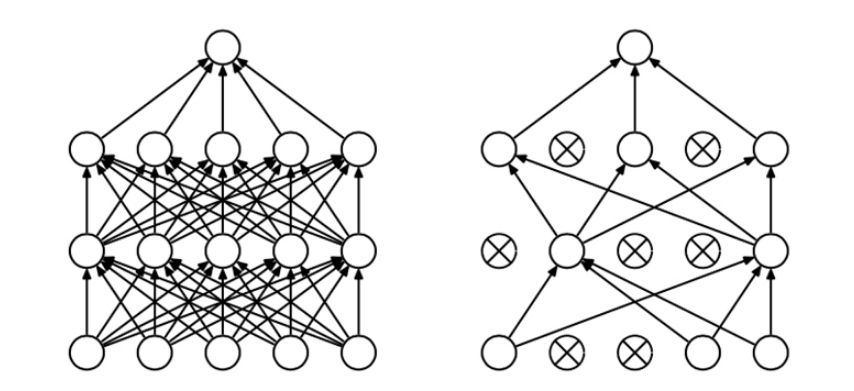

In [21]:
Image(filename=photo_paths[13],width=1000,height=500)

这样在每个批的训练中，我们都是在训练不同的神经网络，最后在测试的时候再使用全部的神经元，以此增强模型的泛化能力。

### **2.3 运行模型**

这样在每个批的训练中，我们都是在训练不同的神经网络，最后在测试的时候再使用全部的神经元，以此增强模型的泛化能力。

In [22]:
def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，batch_size行num_classes列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[1] # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标
    rights = pred.eq(labels.data.view_as(pred)).sum() #将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    return rights, len(labels) #返回正确的数量和这一次一共比较了多少元素


In [23]:
net = ConvNet() #新建一个卷积神经网络的实例，此时ConvNet的__init__函数就会被自动调用

criterion = nn.CrossEntropyLoss() #Loss函数的定义，交叉熵
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #定义优化器，普通的随机梯度下降算法

record = [] #记录准确率等数值的容器
weights = [] #每若干步就记录一次卷积核

#开始训练循环
for epoch in range(num_epochs):

    train_rights = [] #记录训练数据集准确率的容器

    ''' 下面的enumerate是构造一个枚举器的作用。就是我们在对train_loader做循环迭代的时候，enumerate会自动吐出一个数字指示我们循环了几次
     这个数字就被记录在了batch_idx之中，它就等于0，1，2，……
     train_loader每迭代一次，就会吐出来一对数据data和target，分别对应着一个batch中的手写数字图，以及对应的标签。'''

    for batch_idx, (data, target) in enumerate(train_loader):  #针对容器中的每一个批进行循环
        data, target = data.clone().requires_grad_(True), target.clone().detach()  #data为一批图像，target为一批标签
        net.train() # 给网络模型做标记，标志说模型正在训练集上训练，
                    #这种区分主要是为了打开关闭net的training标志，从而决定是否运行dropout

        output = net(data) #神经网络完成一次前馈的计算过程，得到预测输出output
        loss = criterion(output, target) #将output与标签target比较，计算误差
        optimizer.zero_grad() #清空梯度
        loss.backward() #反向传播
        optimizer.step() #一步随机梯度下降算法
        right = rightness(output, target) #计算准确率所需数值，返回数值为（正确样例数，总样本数）
        train_rights.append(right) #将计算结果装到列表容器train_rights中


        if batch_idx % 100 == 0: #每间隔100个batch执行一次打印等操作

            net.eval() # 给网络模型做标记，标志说模型在训练集上训练
            val_rights = [] #记录校验数据集准确率的容器

            '''开始在校验数据集上做循环，计算校验集上面的准确度'''
            for (data, target) in validation_loader:
                data, target = data.clone().requires_grad_(True), target.clone().detach()
                output = net(data) #完成一次前馈计算过程，得到目前训练得到的模型net在校验数据集上的表现
                right = rightness(output, target) #计算准确率所需数值，返回正确的数值为（正确样例数，总样本数）
                val_rights.append(right)

            # 分别计算在目前已经计算过的测试数据集，以及全部校验集上模型的表现：分类准确率
            #train_r为一个二元组，分别记录目前已经经历过的所有训练集中分类正确的数量和该集合中总的样本数，
            #train_r[0]/train_r[1]就是训练集的分类准确度，同样，val_r[0]/val_r[1]就是校验集上的分类准确度
            train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
            #val_r为一个二元组，分别记录校验集中分类正确的数量和该集合中总的样本数
            val_r = (sum([tup[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))
            #打印准确率等数值，其中正确率为本训练周期Epoch开始后到目前撮的正确率的平均值
            print(val_r)
            print('训练周期: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t训练正确率: {:.2f}%\t校验正确率: {:.2f}%'.format(
                epoch, batch_idx * batch_size, len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data,
                100. * train_r[0].numpy() / train_r[1],
                100. * val_r[0].numpy() / val_r[1]))

            #将准确率和权重等数值加载到容器中，以方便后续处理
            record.append((100 - 100. * train_r[0] / train_r[1], 100 - 100. * val_r[0] / val_r[1]))

            # weights记录了训练周期中所有卷积核的演化过程。net.conv1.weight就提取出了第一层卷积核的权重
            # clone的意思就是将weight.data中的数据做一个拷贝放到列表中，否则当weight.data变化的时候，列表中的每一项数值也会联动
            '''这里使用clone这个函数很重要'''
            weights.append([net.conv1.weight.data.clone(), net.conv1.bias.data.clone(),
                            net.conv2.weight.data.clone(), net.conv2.bias.data.clone()])


(tensor(529), 5000)
训练周期: 0 [0/60000 (0%)]	Loss: 2.304267	训练正确率: 14.06%	校验正确率: 10.58%
(tensor(529), 5000)
训练周期: 0 [6400/60000 (11%)]	Loss: 2.288706	训练正确率: 11.06%	校验正确率: 10.58%
(tensor(591), 5000)
训练周期: 0 [12800/60000 (21%)]	Loss: 2.264389	训练正确率: 12.37%	校验正确率: 11.82%
(tensor(1573), 5000)
训练周期: 0 [19200/60000 (32%)]	Loss: 2.228210	训练正确率: 15.58%	校验正确率: 31.46%
(tensor(3148), 5000)
训练周期: 0 [25600/60000 (43%)]	Loss: 1.947033	训练正确率: 21.03%	校验正确率: 62.96%
(tensor(3775), 5000)
训练周期: 0 [32000/60000 (53%)]	Loss: 1.146713	训练正确率: 28.93%	校验正确率: 75.50%
(tensor(4133), 5000)
训练周期: 0 [38400/60000 (64%)]	Loss: 0.644507	训练正确率: 36.71%	校验正确率: 82.66%
(tensor(4212), 5000)
训练周期: 0 [44800/60000 (75%)]	Loss: 0.528981	训练正确率: 43.00%	校验正确率: 84.24%
(tensor(4279), 5000)
训练周期: 0 [51200/60000 (85%)]	Loss: 0.335123	训练正确率: 48.20%	校验正确率: 85.58%
(tensor(4331), 5000)
训练周期: 0 [57600/60000 (96%)]	Loss: 0.595307	训练正确率: 52.38%	校验正确率: 86.62%
(tensor(4393), 5000)
训练周期: 1 [0/60000 (0%)]	Loss: 0.456866	训练正确率: 90.62%	校验正确率: 87.86%
(t

在这段代码中，我们需要关注两个细节：一个是出现在训练数据循环中的net.train()，另一个是出现在校验数据循环中的net.eval()。

它们都是为了打开或关闭dropout()，net.train()相当于把所有的dropout层打开，而net.eval()相当于把它们关闭。为了防止过拟合，dropout操作可以在训练阶段将一部分神经元随机关闭，而在校验和测试的时候再打开。

运行这段程序之后，我们创建的这个卷积神经网络识别手写数字的准确率已经提高到98%左右了。如果我们增加卷积层，或者使用其他卷积模型，识别准确率将会更高。

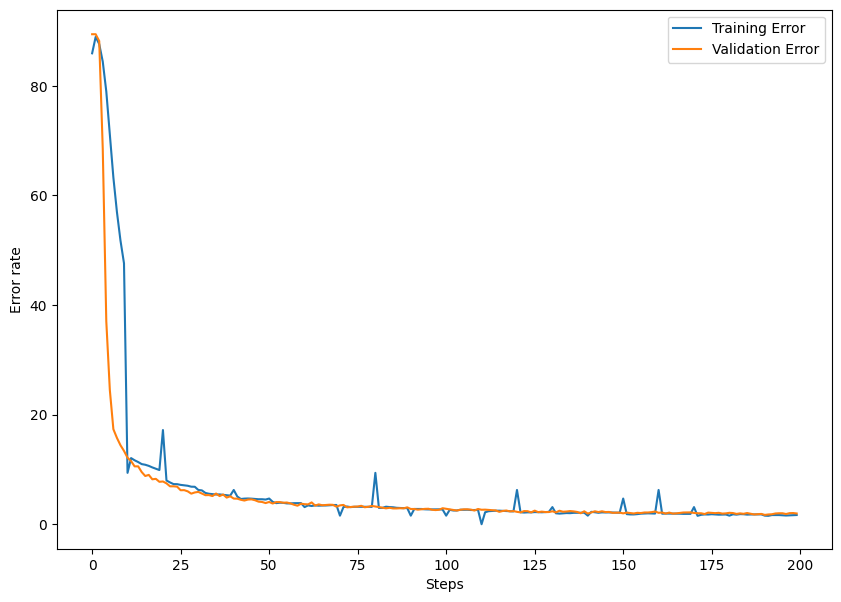

In [24]:
plt.figure(figsize=(10, 7))
train_errors = [item[0] for item in record]
val_errors = [item[1] for item in record]
plt.plot(train_errors, label='Training Error')
plt.plot(val_errors, label='Validation Error')
plt.xlabel('Steps')
plt.ylabel('Error rate')
plt.legend(loc='upper right')
plt.show()



### **2.4 测试模型**

我们可以尝试用训练过的模型在数据集上做测试 观察准确率和误差曲线。

In [25]:
# 在测试集上分批运行，并计算总的准确率
net.eval() # 标志着模型当前为运行阶段
vals = [] # 记录准确率所用列表

# 对测试集进行循环
for data, target in test_loader:
    data, target = data.clone().detach().requires_grad_(True), target.clone().detach()
    output = net(data) # 将特征数据输入网络，得到分类的输出
    val = rightness(output, target) # 获得正确样本数以及总样本数
    vals.append(val) # 记录结果

# 计算准确率
rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0] / rights[1]
right_rate

tensor(0.9922)

标签是： 3


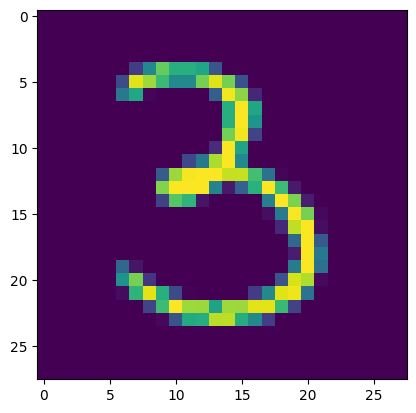

In [26]:
#随便从测试集中读入一张图片，并检验模型的分类结果，并绘制出来
idx = 4004
muteimg = test_dataset[idx][0].numpy()
plt.imshow(muteimg[0,...])
print('标签是：',test_dataset[idx][1])

模型在测试集和校验集上的表现都很不错，卷积神经网络的泛化能力都很强。

## **3. 剖析卷积神经网络**

对我们训练好的卷积神经网络进行剖析，并主要关注下面几个问题。




*   第一层卷积核训练得到了什么？

*   输入特定图像的时候，第一层卷积核所对应的4个特征图是什么样的？
*   第二层卷积核都是什么?


*   对于给定输入图像，第二层卷积核所对应的特征图是什么样的？





### **3.1 第一层卷积核与特征图**

在之前对ConvNet的定义中，我们将第一层conv2d定义成4个输入通道，**使用了4个不同的卷积核，**输出4个特征图作为第一层的输出：

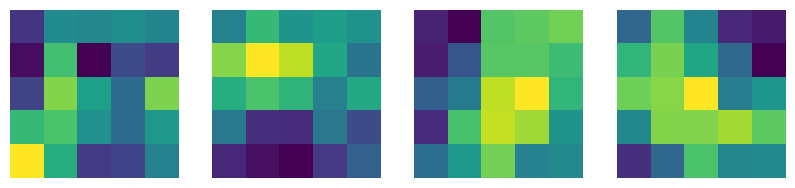

In [27]:
#提取第一层卷积层的卷积核
plt.figure(figsize = (10, 7))
for i in range(4):
    plt.subplot(1,4,i + 1)
    plt.axis('off')
    plt.imshow(net.conv1.weight.data.numpy()[i,0,...]) #提取第一层卷积核中的权重值，注意conv1是net的属性

上面就是四个卷积核的可视化结果。这些各自有不同数值，各不相同，需要结合每个卷积核对应的特征图才能进行解读。

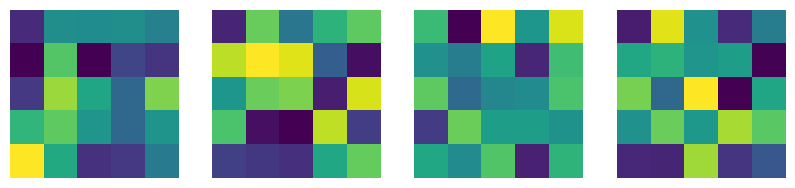

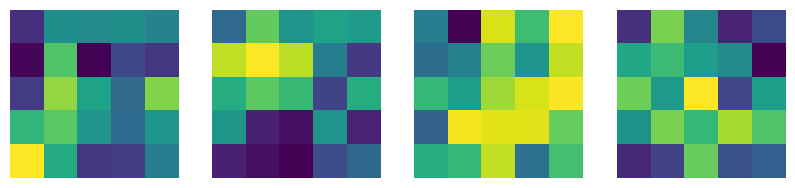

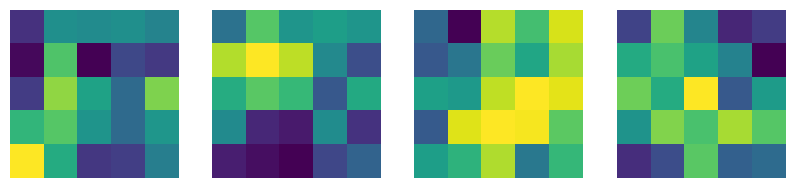

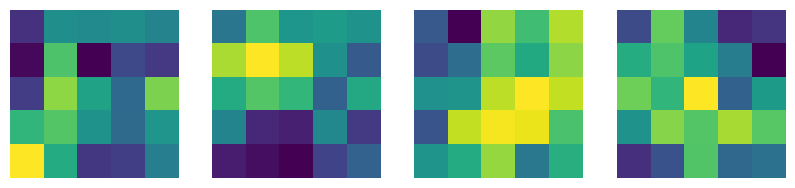

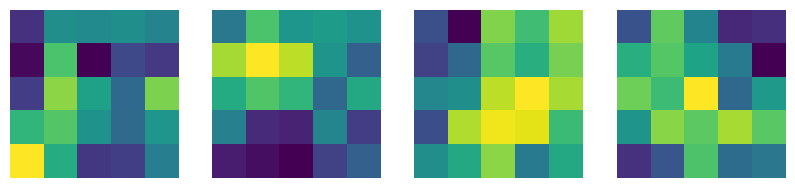

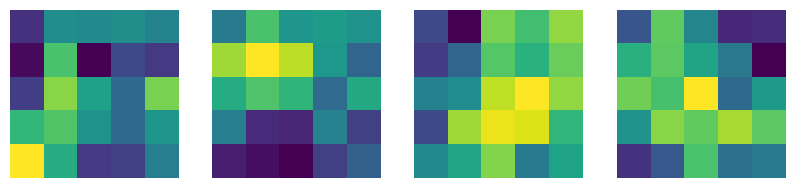

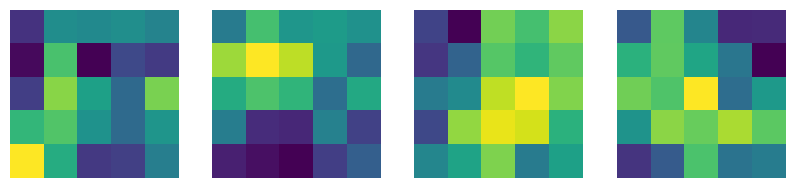

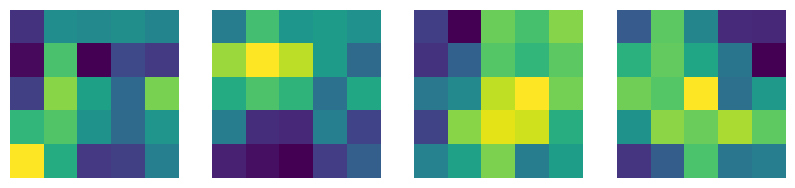

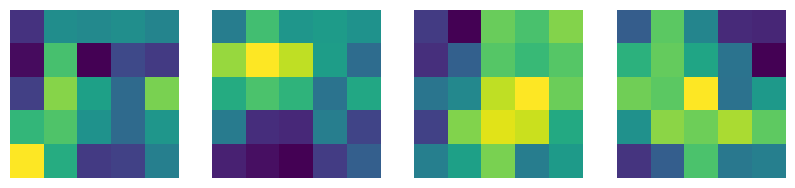

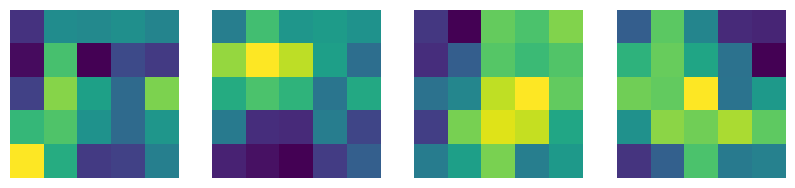

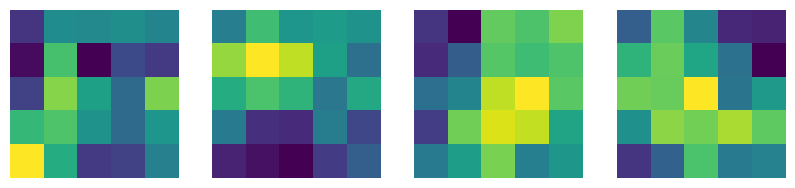

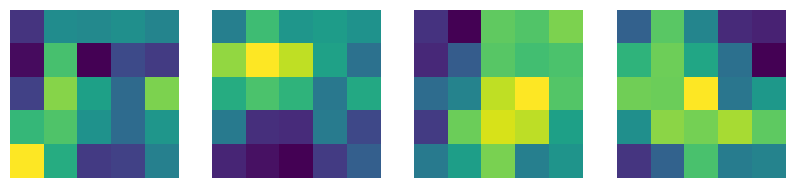

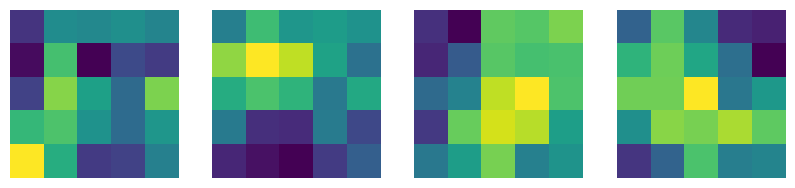

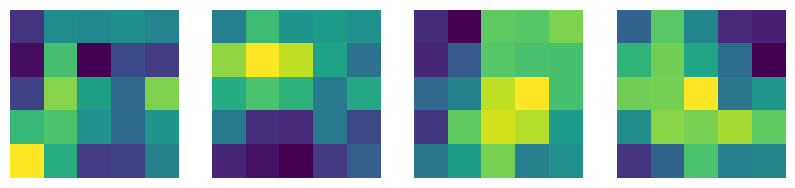

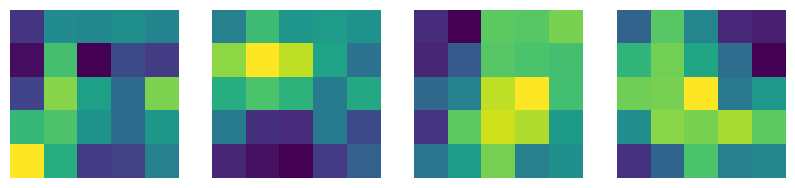

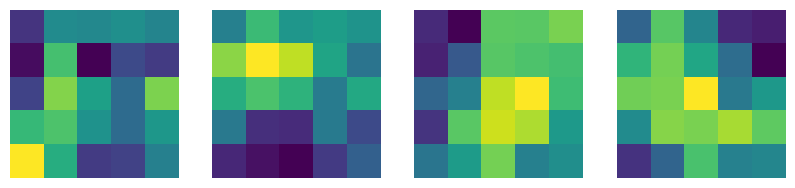

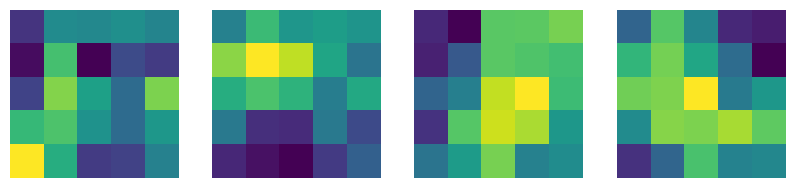

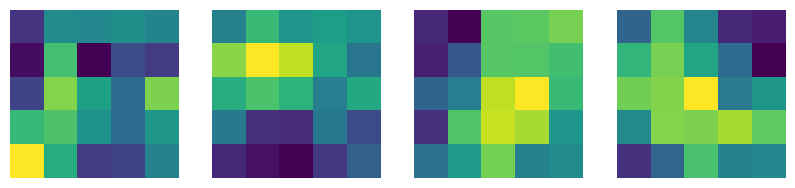

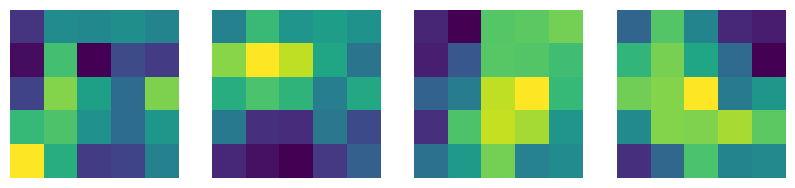

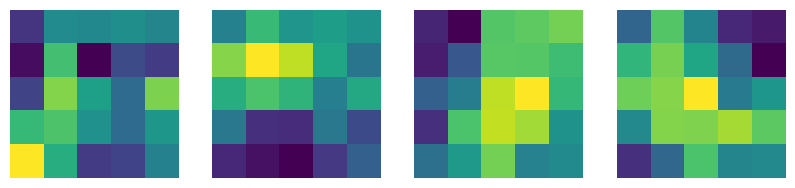

In [28]:
# 将记录在容器中的卷积核权重历史演化数据打印出来
i = 0
for tup in weights:
    if i % 10 == 0 :
        layer1 = tup[0]
        fig = plt.figure(figsize = (10, 7))
        for j in range(4):
            plt.subplot(1, 4, j + 1)
            plt.axis('off')
            plt.imshow(layer1.numpy()[j,0,...])
    i += 1

当输入图像3之后，我们可以将4个卷积核对应的4个特征图打印出来、

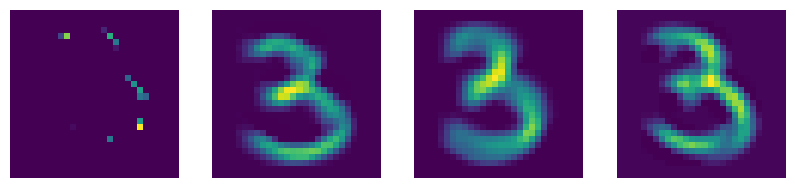

In [29]:
#调用net的retrieve_features方法可以抽取出喂入当前数据后吐出来的所有特征图（第一个卷积和第二个卷积层）

#首先定义读入的图片

#它是从test_dataset中提取第idx个批次的第0个图，其次unsqueeze的作用是在最前面添加一维，
#目的是为了让这个input_x的tensor是四维的，这样才能输入给net。补充的那一维表示batch。
input_x = test_dataset[idx][0].unsqueeze(0)
feature_maps = net.retrieve_features(input_x) #feature_maps是有两个元素的列表，分别表示第一层和第二层卷积的所有特征图

plt.figure(figsize = (10, 7))

#有四个特征图，循环把它们打印出来
for i in range(4):
    plt.subplot(1,4,i + 1)
    plt.axis('off')
    plt.imshow(feature_maps[0][0, i,...].data.numpy())


从第一层的特征图可以看到，有些卷积核会对图像做模糊化处理。如果读者熟悉计算机视觉，就会知道均值滤波可以达到这样的效果；有些卷积核会强化边缘并进行提取，对应经典的Gabor滤波或者Sobel滤波。由此可见，我们的卷积核确实可以通过学习样本获得提取边缘的能力，从而实现一些传统计算机视觉中经典算法的效果。


### **3.2 第二层卷积核与特征图**

同样，我们可以对第二层所有的卷积核进行可视化，如下：

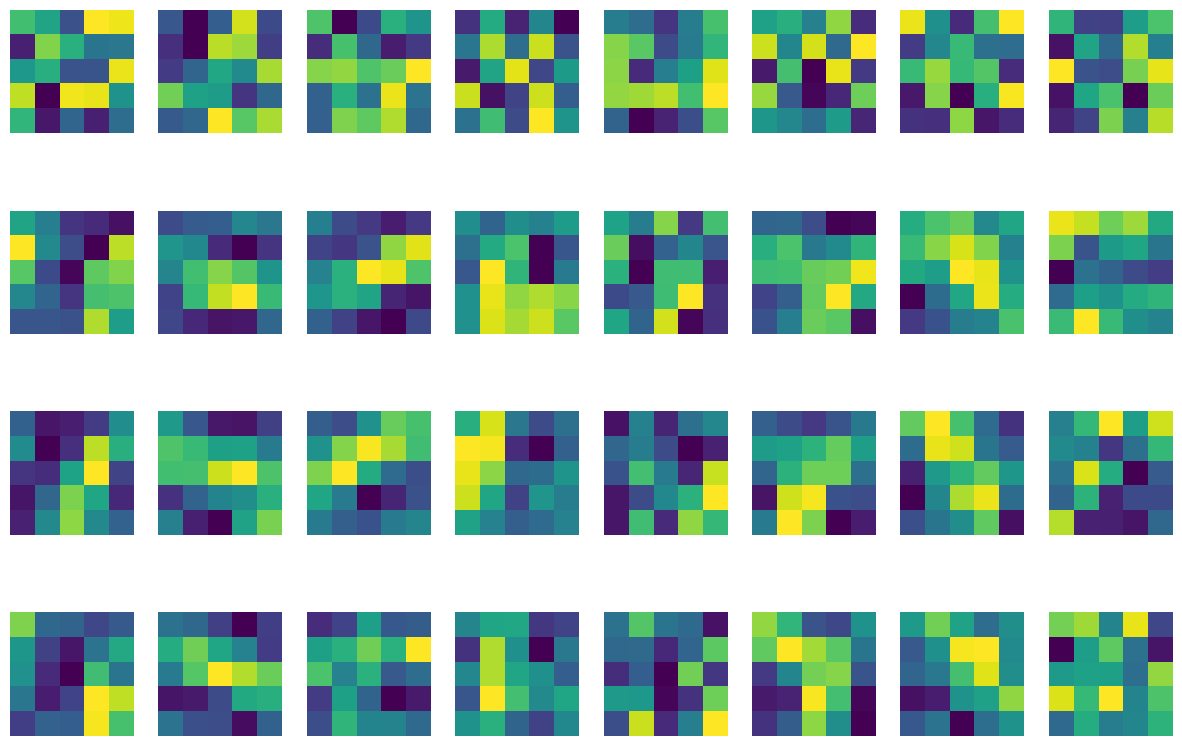

In [30]:
# 绘制第二层的卷积核，每一列对应一个卷积核，一共8个卷积核
plt.figure(figsize = (15, 10))
for i in range(4):
    for j in range(8):
        plt.subplot(4, 8, i * 8 + j + 1)
        plt.axis('off')
        plt.imshow(net.conv2.weight.data.numpy()[j, i,...])

上图中每一列为一个卷积核（注意，由于第2层卷积层的输入尺寸为（28,28,4），所以每个卷积核是一个（5,5,4）的张量。） 第二层一共有8个卷积核，所以一共有8列。

绘制手写数字3之后第2层的特征图

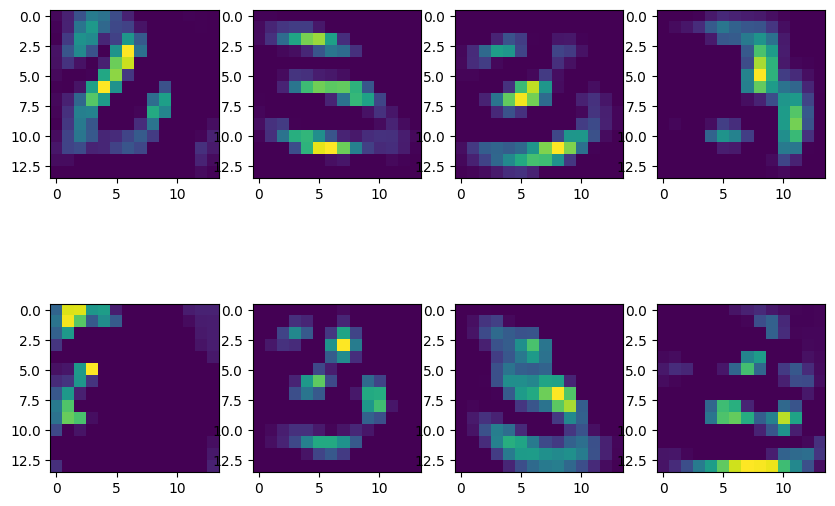

In [31]:
# 绘制第二层的特征图，一共有8个
plt.figure(figsize = (10,7))
for i in range(8):
  plt.subplot(2,4,i+1)
  plt.imshow(feature_maps[1][0,i,...].data.numpy())

从图中可以看出，图像的抽象程度更高了。由于池化的作用，一些多余的图像信息被丢弃了，体现了多层卷积神经网络的抽象提取能力。

### **3.3 卷积神经网络的健壮性实验**

卷积神经网络的特征提取能力已经得到了验证。 接下来可以看他消除局部相关性的能力（健壮性？）。将进行下面的测试，当输入的数字在图像上进行一定程度的平移后，系统是否能辨认这个数字。

我们随机挑选一张测试图像，把它往左平移$w$个单位，观察分类结果是否有变化，以及两层卷积对应的特征图有何变化。

平移输入图像中的数字，如下：

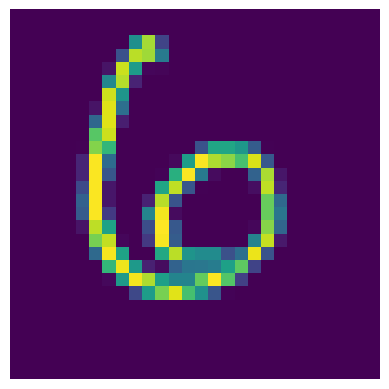

In [35]:
# 提取中test_dataset中的第idx个批次的第0个图的第0个通道对应的图像，定义为a。
a = test_dataset[idx][0][0]

# 平移后的新图像将放到b中。根据a给b赋值。
b = torch.zeros(a.size()) #全0的28*28的矩阵
w = 3 #平移的长度为3个像素

# 对于b中的任意像素i,j，它等于a中的i,j+w这个位置的像素
for i in range(a.size()[0]):
    for j in range(0, a.size()[1] - w):
        b[i, j] = a[i, j + w]

# 将b画出来
muteimg = b.numpy()
plt.axis('off')
plt.imshow(muteimg)

我们把数字平移了3个像素 效果如上

tensor([6])


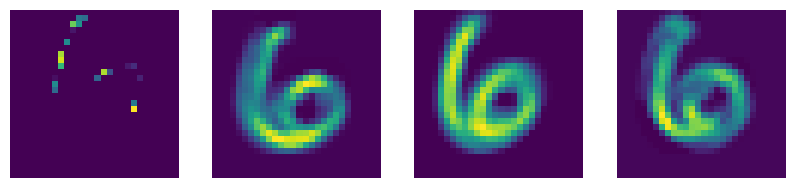

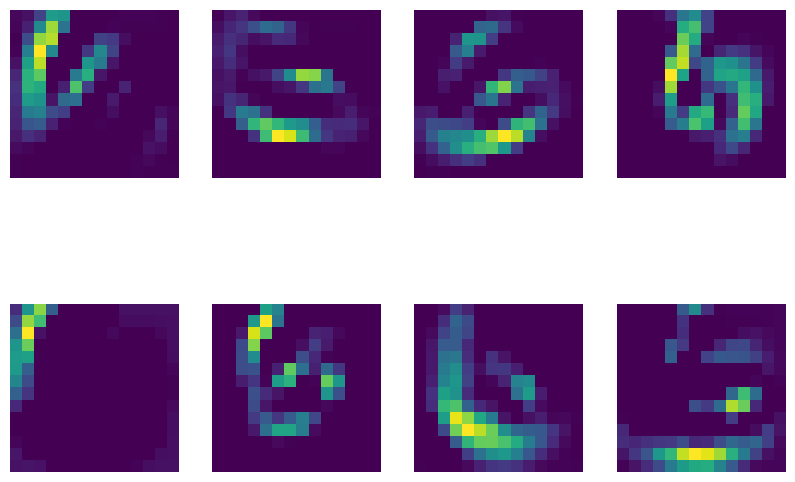

In [36]:

# 把b喂给神经网络，得到分类结果pred（prediction是预测的每一个类别的概率的对数值），并把结果打印出来
prediction = net(b.unsqueeze(0).unsqueeze(0))
pred = torch.max(prediction.data, 1)[1]
print(pred)

#提取b对应的featuremap结果
feature_maps = net.retrieve_features(b.unsqueeze(0).unsqueeze(0))

plt.figure(figsize = (10, 7))
for i in range(4):
    plt.subplot(1,4,i + 1)
    plt.axis('off')
    plt.imshow(feature_maps[0][0, i,...].data.numpy())

plt.figure(figsize = (10, 7))
for i in range(8):
    plt.subplot(2,4,i + 1)
    plt.axis('off')

    plt.imshow(feature_maps[1][0, i,...].data.numpy())

网格最后打印的结果是6，说明模型 能够识别对应的数字，对于3像素点的平移具有较好地抗干扰性。 平移前后的特征图基本没有什么差别，说明池化运算进行了更大尺度的特征提取，所以局部的小变化并不好引起高层特征图的更大变化。

**因此，卷积神经网络具有很强的健壮性，即抗干扰能力。**